# Imports and definitions

## Imports

In [1]:
import os
import glob
import sys

import numpy as np
import healpy as hp

from scipy import signal
from scipy.fftpack import fft, fft2, fftshift, fftfreq

# Plotting
import cmocean
import cmocean.cm as cmo
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import matplotlib.pyplot as pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib import ticker

# HYDRA (for HERA antennas)
sys.path.append("/home/katgla/Documents/hera/Hydra") # change this to your own path
import hydra
from hydra.utils import build_hex_array

<ipython-input-1-53e3bc4e04bd>:19: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.titlepad'] = 16
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams["errorbar.capsize"] = 5

## Functions definitions

### Mode conversion functions

#### `healpy2alms()`

In [3]:
def healpy2alms(healpy_modes):
    """
    Takes a complex array of alms (positive modes only) and turns into
    a real array split as [real, imag] making sure to remove the 
    m=0 modes from the imag-part.
      
     Parameters
    ----------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
    
    Returns
    -------
    * alms (ndarray (floats))
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zero 
            and is split into a real (first) and imag (second) part. The
            Imag part is smaller as the m=0 modes shouldn't contain and 
            imaginary part. 
    """
    lmax = hp.sphtfunc.Alm.getlmax(healpy_modes.size) # to remove the m=0 imag modes
    alms = np.concatenate((healpy_modes.real,healpy_modes.imag[(lmax+1):]))
        
    return alms    

#### `alms2healpy()`

In [4]:
def alms2healpy(alms, lmax):
    """
    Takes a real array split as [real, imag] (without the m=0 modes 
    imag-part) and turns it into a complex array of alms (positive 
    modes only) ordered as in HEALpy.
      
     Parameters
    ----------
    * alms (ndarray (floats))
            The array represents all positive (+m) modes including zero 
            and has double length, as real and imaginary values are split. 
            The first half is the real values.

    
    Returns
    -------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
            
    """
    
    real_imag_split_index = int((np.size(alms)+(lmax+1))/2)
    real = alms[:real_imag_split_index]
    
    add_imag_m0_modes = np.zeros(lmax+1)
    imag = np.concatenate((add_imag_m0_modes, alms[real_imag_split_index:]))
    
    healpy_modes = real + 1.j*imag
    
    return healpy_modes

### Plotting functions

#### `alm_plot()`

In [5]:
def alm_plot(x_true, x_solns, lmax, title, filename, ylabel, xlabel, xlim=None, ylim=None, pdf=True, display = False):
    
    # Choose colours
    cmap20 = discrete_cmap(lmax,cmo.thermal)
    bgcolor = cmap20(16)
    linecolor = '0.5'
    
    # Convert to HEALpy alms for better intuition
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    hp_true = alms2healpy(x_true,lmax)
    hp_solns = np.empty((x_solns.shape[0],hp_true.shape[0]),dtype=np.dtype(np.complex128))
    idx = 0
    for x_soln in x_solns:
        hp_soln = alms2healpy(x_soln,lmax)
        hp_solns[idx] = hp_soln
        idx += 1
        
    hp_soln_mean_real = np.mean(a=hp_solns.real, axis=0) 
    hp_soln_std_real = np.sqrt(np.var(a=hp_solns.real,axis=0))
    
    hp_soln_mean_imag = np.mean(a=hp_solns.imag, axis=0) 
    hp_soln_std_imag = np.sqrt(np.var(a=hp_solns.imag,axis=0))
    
    # Move points slightly to better see the different m-modes
    ell_em_labels = [float(ell) for ell in ells]
    em_idx = 0
    for em in ems:
        adjust = em/lmax*0.9
        ell_em_labels[em_idx] += adjust
        em_idx += 1
    
    ## PLOTTING SECTION
    fig, ax = plt.subplots(nrows=2, figsize=(16,6), sharex=True) 
    fig.subplots_adjust(hspace=0)
    
    for _ax in ax: 
        _ax.axhline(0,ls="-",color=linecolor, lw=2, alpha=0.5) 
        _ax.set_ylim([-109,109])
        _ax.set_xlim([-0.3,21.5])
        _ax.tick_params(length=6)

    # Plotting errorbars, marking out m=0 imag modes and outlier modes.
    outlier_ells_real = []
    ell_idx = 0
    for em in ems:
        # Real part
        diff_real = (hp_soln_mean_real-hp_true.real)[ell_idx]
        if diff_real > 100:
            real = ax[0].scatter(x=ell_em_labels[ell_idx], y=100, 
                                 marker='^', label='imag', color=cmap20(em))
            if np.any(np.isin(outlier_ells_real,ems[ell_idx])):
                ax[0].text(ell_em_labels[ell_idx]+0.2, 95, f'{diff_real:.0f}', va='center', rotation='horizontal')
            else: 
                ax[0].text(ell_em_labels[ell_idx]-0.3, 83, f'{diff_real:.0f}', va='center', rotation='horizontal')
                outlier_ells_real = np.append(outlier_ells_real,ells[ell_idx])
                        
        elif diff_real < -100:
            real = ax[0].scatter(x=ell_em_labels[ell_idx], y=-100, 
                                  marker='v', label='imag', color=cmap20(em))
            if np.any(np.isin(outlier_ells_real,ems[ell_idx])):
                ax[0].text(ell_em_labels[ell_idx]+0.2, -95, f'{diff_real:.0f}', va='center', rotation='horizontal')
            else: 
                ax[0].text(ell_em_labels[ell_idx]-0.3, -84, f'{diff_real:.0f}', va='center', rotation='horizontal')
                outlier_ells_real = np.append(outlier_ells_real,ells[ell_idx])
            
        else:
            real = ax[0].errorbar(x=ell_em_labels[ell_idx], y=diff_real, yerr=hp_soln_std_real[ell_idx], 
                                  fmt='o', label='real', color=cmap20(em))#,markerfacecolor=cmap20(em), markeredgecolor=bgcolor
                
        ## Imaginary. mark out the m=0 with an X
        diff_imag = (hp_soln_mean_imag-hp_true.imag)[ell_idx]
        if ems[ell_idx] == 0:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=diff_imag, 
              marker='x', label='imag', color=cmap20(em))#, color='white')#, markeredgecolor=cmap20(em))
        elif diff_imag > 100:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=100, 
                                 marker='^', label='imag', color=cmap20(em))
            ax[1].text(ell_em_labels[ell_idx]-0.4, 83, f'{diff_imag:.0f}', va='center', rotation='horizontal')
        elif diff_imag < -100:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=-100, 
                                  marker='v', label='imag', color=cmap20(em))
            ax[1].text(ell_em_labels[ell_idx]-0.4, -84, f'{diff_imag:.0f}', va='center', rotation='horizontal')
        else:
            imag = ax[1].errorbar(x=ell_em_labels[ell_idx], y=diff_imag, yerr=hp_soln_std_imag[ell_idx], 
                          fmt='o', label='imag', color=cmap20(em))#, markerfacecolor=cmap20(em), markeredgecolor=bgcolor)
        
        ell_idx+=1
        
    # customising ticks
    ax[0].tick_params(bottom=True, direction='inout')
    ax[1].tick_params(top=True, direction='inout')

    ax[0].tick_params(left=True, direction='out')
    ax[1].tick_params(left=True, direction='out')
    
    # Plot labels "real" or "imag"
    ax[0].text(20,-70,r'real', 
         bbox=dict(boxstyle="round",
                      fc=bgcolor, 
                      ec=None, 
                      lw=0, 
                      alpha=0.1))
    
    ax[1].text(19.8,-70,r'imag', 
         bbox=dict(boxstyle="round",
                  fc=bgcolor, 
                  ec=None, 
                  lw=0, 
                  alpha=0.1))
    
    # custom colorbar for m-values
    cax = fig.add_axes([0.585, 0.835, 0.3, 0.02]) #left, bottom, width, height
    norm = mpl.colors.Normalize(vmin=0, vmax=lmax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap20,
                                    norm=norm,
                                    orientation='horizontal')
    cbar.set_label(r'$m$-value')
    
    # title and labels
    ax[0].set_title(title)
    ax[1].set_xlabel(xlabel, labelpad=8)
    fig.text(0.06, 0.5, ylabel, va='center', rotation='vertical')
    ax[1].set_xticks(np.arange(0,lmax+1,1)) # set xticks and labels to be integer and stop at lmax
    
    if pdf:
        filetype = '.pdf'
    else:
        filetype = '.png'
    # ax[0].yscale('log')
    plt.savefig(figpath+filename+filetype,
            bbox_inches='tight',
            transparent=False,
            dpi=300)#fig.dpi)

    if display == False:
        plt.close()

#### `delta_l_plot()`

In [6]:
def delta_l_plot(x_solns, x_true, lmax, filename, log=True,display=False):
    # Colours
    cl_color = discrete_cmap(10,cmo.thermal)(7)
    delta_l_color = discrete_cmap(10,cmo.thermal)(1)
    
    residuals = x_solns - x_true
    residuals_hp = np.array([alms2healpy(residual,lmax) for residual in residuals])
    
    # true sky powerspectrum        
    # cl_true = hp.sphtfunc.alm2cl(alms2healpy(x_true,lmax))
    x_true_hp = alms2healpy(x_true,lmax)
    cl_true = np.zeros(lmax+1)
    
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    delta_l = np.zeros(lmax+1, dtype = np.complex128)
    std = np.zeros(lmax+1)
    
    for ell in np.arange(lmax+1):
        # Calculate \Sum_m |a_est - a_true|^2
        idx = np.where(ells==ell)
        m_summed = np.array([np.dot(residual_hp.conj()[idx],residual_hp[idx]) for residual_hp in residuals_hp]) # purely real now
        
        # Take the mean over all samples and normalise \Delta_l and C_l
        delta_l[ell] = (ell*(ell+1)) * (1/(ell + 1)) * np.mean(a=m_summed, axis=0)
        # cl_true[ell] *= (ell*(ell+1)) * (1/(ell + 1))
        
        # Calulate erros
        std[ell] = np.sqrt(np.var(a=m_summed,axis=0))  # Is this meant to have the front factor too??
        
        # C_ell = 1/(l+1) sum_m |a_lm|^2 
        m_summed_true = np.dot(x_true_hp.conj()[idx],x_true_hp[idx])
        if m_summed_true.imag == 1.j*0:
            cl_true[ell] =  (ell*(ell+1)) * 1/(ell+1) * m_summed_true.real

    fig, ax = plt.subplots(nrows=1, figsize=(10,6)) 
    ax.errorbar(x=np.arange(lmax+1),
                y=delta_l.real,
                yerr=std,
                fmt='o',
                label=r'$(\ell(\ell+1))\,\Delta_{\ell}^2$',
                color=delta_l_color)
    
    ax.plot(np.arange(lmax+1),
            cl_true,
            'o',
            label=r'$(\ell(\ell+1))\,C_{\ell,\large{\textup{true}}}$',
            color=cl_color)
    
    ax.set_xlabel(r'$\ell$-value')
    #ax.set_ylabel(r'$(1/(\ell+1))\,\Delta_{\ell}^2$')
    if log: ax.set_yscale('log')
    # set xticks and labels to be integer and stop at lmax
    ax.set_xticks(np.arange(0,lmax+1,1)) 
    
    # Fixing the order of the labels
    ax.legend(*([ label[i] for i in [1,0] ] for label in plt.gca().get_legend_handles_labels()), loc='best')
    
    plt.savefig(figpath+filename+'.pdf',
            bbox_inches='tight',
            transparent=False,
            dpi=300)#fig.dpi)

    if display == False:
        plt.close()

#### `var_plot()`

In [7]:
def var_plot(x_solns, x_true, lmax, filename, x_priors=None, display=False):
    cmap10 = discrete_cmap(10,cmo.thermal)
    color = cmap10(1)
    p_color = cmap10(7)

    x_true_hp = alms2healpy(x_true,lmax)
    
    x_solns_hp = np.array([alms2healpy(x_soln,lmax) for x_soln in x_solns])
    var_real = np.var(a=x_solns_hp.real,axis=0)
    var_imag = np.var(a=x_solns_hp.imag,axis=0)
    
    if np.any(x_priors) != None:
        x_priors_hp = np.array([alms2healpy(x_prior,lmax) for x_prior in x_priors])
        p_var_real = np.var(a=x_priors_hp.real,axis=0)
        p_var_imag = np.var(a=x_priors_hp.imag,axis=0)
        p_var = np.zeros(lmax+1)
        
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    var = np.zeros(lmax+1)
    cl_true = np.zeros(lmax+1)
    
    for ell in np.arange(lmax+1):
        # Calculate <\sigma_alm >_m
        idx = np.where(ells==ell)
        
        # sum over m-mode and real/imag
        var_summed = np.sum([var_real[idx],var_imag[idx]])
        
        # Normalise
        var[ell] = 1/(2*(ell+1)) * var_summed
        
        # Repeat if there is a prior-only file
        if np.any(x_priors) != None:
            p_var_summed = np.sum([p_var_real[idx],p_var_imag[idx]])
            p_var[ell] = 1/(2*(ell+1)) * p_var_summed
        
        # C_ell = 1/(l+1) sum_m |a_lm|^2 
        m_summed_true = np.dot(x_true_hp.conj()[idx],x_true_hp[idx])
        if m_summed_true.imag == 1.j*0:
            cl_true[ell] = 1/(ell+1) * m_summed_true.real

    # Plot of the variance
    fig, ax = plt.subplots(nrows=1, figsize=(10,6))    
    ax.plot(np.arange(lmax+1),
            var,
            '.',
            color=color,
            label='estimated')
    
    # Repeat if there is a prior-only file
    if np.any(x_priors) != None:
        ax.plot(np.arange(lmax+1),
                p_var,
                '.',
                color=p_color,
                label='prior-only')
        ax.legend()
    ax.set_yscale('log')
    
    ax.set_xlabel(r'$\ell$-value')
    ax.set_ylabel(r'$\langle{\sigma}^2_{a_{\ell m}}\rangle_{m,\large{\textup{re,im}}}$')
    ax.set_xticks(np.arange(0,lmax+1,1)) # set xticks and labels to be integer and stop at lmax
    
    plt.savefig(figpath+filename+'.pdf',
        bbox_inches='tight',
        transparent=False,
        dpi=300)#fig.dpi)
    
    if display == False:
        plt.close()
    
    
    ## Divided by Cl_true
    fig, ax = plt.subplots(nrows=1, figsize=(10,6))    
    ax.plot(np.arange(lmax+1),
            var/cl_true,
            '.',
            color=color,
            label='estimated')
    # Repeat if there is a prior-only file
    if np.any(x_priors) != None:
        ax.plot(np.arange(lmax+1),
                p_var/cl_true,
                '.',
                color=p_color,
                label='prior-only')
        ax.legend()
    
    ax.set_xlabel(r'$\ell$-value')
    ax.set_ylabel(r'$\langle{\sigma}^2_{a_{\ell m}}\rangle_{m,\large{\textup{re,im}}}/C_{\ell,\large{\textup{true}}}$')
    ax.set_xticks(np.arange(0,lmax+1,1)) # set xticks and labels to be integer and stop at lmax
    
    plt.savefig(figpath+filename+'_c_ell'+'.pdf',
        bbox_inches='tight',
        transparent=False,
        dpi=300)#fig.dpi)

    if display == False:
        plt.close()

#### `z_score_histogram()`

In [8]:
def z_score_histogram(x_true, x_solns, lmax, title, xlabel, ylabel, xlim=None,filename='', display=False):
    
    # Convert to HEALpy alms for better intuition
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    hp_true = alms2healpy(x_true,lmax)
    hp_solns = np.empty((x_solns.shape[0],hp_true.shape[0]),dtype=np.dtype(np.complex128))
    # idx = 0
    for idx, x_soln in enumerate(x_solns):
        hp_soln = alms2healpy(x_soln,lmax)
        hp_solns[idx] = hp_soln
        # idx += 1
        
    hp_soln_mean_real = np.mean(a=hp_solns.real, axis=0) 
    hp_soln_std_real = np.sqrt(np.var(a=hp_solns.real,axis=0))
    
    hp_soln_mean_imag = np.mean(a=hp_solns.imag, axis=0) 
    hp_soln_std_imag = np.sqrt(np.var(a=hp_solns.imag,axis=0))
    
    z_score_real = (hp_soln_mean_real - hp_true.real)/hp_soln_std_real
    z_score_imag = (hp_soln_mean_imag - hp_true.imag)/hp_soln_std_imag
    
    fig, ax = plt.subplots(nrows=1, figsize=(6,6), sharex=True) 
    # fig.subplots_adjust(hspace=0)
    
    ax.hist(z_score_real, 100,# (-5,5),
            log=False,
            density=True,
            alpha = 0.4,
            edgecolor = 'rebeccapurple',
            facecolor = 'rebeccapurple',
            linewidth = 1.5,
            fill=True,
            label='real-part')
    
        
    ax.hist(z_score_imag, 100,# (-5,5),
            log=False,
            density=True,
            alpha = 0.4,
            edgecolor = 'darkorange',
            facecolor = 'darkorange',
            linewidth = 1.5,
            fill=True,
            label='imag-part')
    
    
    # title and labels
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.legend(loc='upper left', frameon=False)
    # fig.text(0.06, 0.5, ylabel, va='center', rotation='vertical')  
    
    if xlim != None:
        ax.set_xlim([xlim[0], xlim[1]])
    
    plt.savefig(figpath+filename+'.pdf',
        bbox_inches='tight',
        transparent=False,
        dpi=fig.dpi)

    if display == False:
        plt.close()

#### `map_plot()`

In [9]:
def map_plot(skymap, title, file_name, vmin=None, vmax=None, logged=False, display=False, pdf=True):
    """
    file_name = name of file
    title = title of figure
    logged: bool
        Take the np.log2 of the data before plotting. Defaults to False.
    """
    cmap= cmo.haline
    
    if logged == False:
        cbar = False
    else:
        skymap = np.log2(skymap)
        cbar = True
        
    if vmin == None:
        vmin = skymap.min()
    if vmax == None:
        vmax = skymap.max()

    if vmin > skymap.min() and vmax >= skymap.max():
        extend = 'min' 
    elif vmax < skymap.max() and vmin <= skymap.min():
        extend = 'max'
    elif vmin > skymap.min() and vmax < skymap.max():
        extend = 'both'
    else:
        extend = 'neither'
    
        
    
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10,6))
    plt.axes(ax1)
    hp.mollview(skymap, title='',
                min = vmin,
                max = vmax,
                cmap=cmap,
                hold=True,
                notext=True,
                #bgcolor="#d5bc5e00",
                cbar = cbar
               )
    hp.graticule()
    plt.title(title, fontsize = "20")
    
    if logged == False:
        # ax2 = fig.add_subplot(ax1)   #used to check actual ax height, as cbar position depends on this
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("bottom", size="5%", pad="1%")

        cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
                 cax=cax, orientation='horizontal', extend=extend)

        # ticks = np.linspace(skymap.min(),skymap.max(),6)    
        ticks = np.linspace(vmin,vmax,6)    
        labels = [f'{tick:.0f}' for tick in ticks]

        cbar.locator = ticker.MaxNLocator(nbins=6)
        cbar.update_ticks()
        cbar.ax.set_xticklabels(labels) 
    
    if pdf:
        filetype = '.pdf'
    else:
        filetype = '.png'
    fig.savefig(file_name+filetype, 
                bbox_inches='tight', 
                #transparent=True, 
                dpi=300,#fig.dpi,
                facecolor='white')
    
    if display == False:
        plt.close()

#### `std_plot()`

In [10]:
def std_plot(skymap, title, file_name, logged=False, display=False):
    """
    file_name = name of file
    title = title of figure
    logged: bool
        Take the np.log2 of the data before plotting. Defaults to False.
    """
    vmin=skymap.min()
    vmax=skymap.max()
    
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10,6))
    plt.axes(ax1)

    cmap=cmo.rain
    
    if logged == False:
        cbar = False
    else:
        skymap = np.log2(skymap)
        cbar = True
    
    hp.mollview(skymap, title=title,
                min = vmin,
                max = vmax,
                cmap=cmap,
                hold=True,
                notext=True,
                #bgcolor="#d5bc5e00",
                cbar = cbar
               )
    hp.graticule()
    
    if logged == False:
        # ax2 = fig.add_subplot(ax1)   #used to check actual ax height, as cbar position depends on this
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("bottom", size="5%", pad="1%")

        cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
                 cax=cax, orientation='horizontal')

        # ticks = np.linspace(skymap.min(),skymap.max(),6)    
        ticks = np.linspace(vmin,vmax,6)
        labels = [fr'{tick:.3f}' for tick in ticks]

        cbar.locator = ticker.MaxNLocator(nbins=6)
        cbar.update_ticks()
        cbar.ax.set_xticklabels(labels) 
    
    fig.savefig(file_name+'.pdf', 
                # bbox_inches='tight', 
                #transparent=True, 
                dpi=300,#fig.dpi,
                facecolor='white')

    if display == False:
        plt.close()

#### `discrete_cmap()`

In [11]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map

    Notes:
    
    If base_cmap is a string or None, you can simply do return plt.cm.get_cmap(base_cmap, N)
    The following works for string, None, or a colormap instance:
    """

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    
    return base.from_list(cmap_name, color_list, N)

#### `discrete_log_map()`

In [12]:
def discrete_log_map(residual_map, title, file_name, mapmin=None, mapmax=None, display=False):
    """
    residual_map = healpy map
    file_name = name of file
    title = title of figure
    """
    
    skymap = np.log10(np.abs(residual_map))
    print(skymap.max(), skymap.min())
    
    # # Set the min/max to be exactly 10 magnitudes. 
    # if np.abs(skymap.min()) >= np.abs(skymap.max()):
    #     #vmin = np.floor(skymap.min())
    #     vmin = np.floor(skymap.min())
    #     vmax = vmin + 10
    # else:
    #     #vmax = np.ceil(skymap.max())
    #     vmax = np.ceil(skymap.max())
    #     vmin = vmax - 10
    
    # If the max isn't provided, assume the max of the current map
    if mapmax == None:
        mapmax = skymap.max()
    
    # Turn into nice half-integer bounds
    if np.ceil(mapmax)-mapmax > 0.5: 
        vmax = np.ceil(mapmax)-0.5
    else: 
        vmax = np.ceil(mapmax)
    
    # If no minimum is provided, make it symmetric
    if mapmin == None:
        vmin = -vmax
    else:
        # Turn provided minimum into a nice half-integer bound too
        if np.abs(np.floor(mapmin)-(mapmin)) > 0.5: 
            vmin = np.floor(mapmin)-0.5
        else: 
            vmin = np.ceil(mapmin)
     
    # Half integer steps         
    steps = int(2*(vmax-vmin))
    
    # cut_ends_cmap = cmocean.tools.crop_by_percent(cmo.thermal_r, 20, which='max', N=None)
    # lighten_cmap = cmocean.tools.lighten(cut_ends_cmap, 0.95)
    cmap = discrete_cmap(steps, cmo.thermal)
    
    # Plot
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10,6))
    hp.mollview(skymap, title=title,
                min = vmin,
                max = vmax,
                cmap = cmap,
                hold = True,
                notext = True,
                #bgcolor = "#d5bc5e00",
                cbar = False
               )
    hp.graticule()

    # Everything for the custom colourbar with tick labels and even magnitudes:
    bounds = np.linspace(vmin,vmax,steps+1)    
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    #ax2 = fig.add_subplot(ax1)   #used to check actual ax height, as cbar position depends on this
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad="1%")


    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal')
    
    ## In case you wanna control the formatting of the labels:
    labels = [f'{bound:.1f}' for bound in bounds]
    cbar.ax.set_xticklabels(labels) 
    

    fig.savefig(file_name+'.pdf', 
                # bbox_inches='tight', 
                transparent=True, 
                dpi=300,#fig.dpi,
                facecolor='white')
    
    if display == False:
        plt.close()

#### `compare_map()`

In [13]:
def compare_map(skymap, title, file_name, vmin=None, vmax=None, cmap=cmo.balance, logged=False, pdf=True, display=False):
    """
    file_name = name of file
    title = title of figure
    logged: bool
        Take the np.log2 of the data before plotting. Defaults to False.
    """
   
    if vmin == None:
        vmin = skymap.min()
    if vmax == None:
        vmax = skymap.max()
        
        
    if vmin > skymap.min() and vmax >= skymap.max():
        extend = 'min' 
    elif vmax < skymap.max() and vmin <= skymap.min():
        extend = 'max'
    elif vmin > skymap.min() and vmax < skymap.max():
        extend = 'both'
    else:
        extend = 'neither'
        
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10,6))
    plt.axes(ax1)

    # cmap=cmo.balance
    
    if logged == False:
        cbar = False
    else:
        skymap = np.log2(skymap)
        cbar = True
    
    hp.mollview(skymap, title='',
                min = vmin,
                max = vmax,
                cmap=cmap,
                hold=True,
                notext=True,
                #bgcolor="#d5bc5e00",
                cbar = cbar
               )
    hp.graticule()
    plt.title(title, fontsize = "20")
    
    if logged == False:
        # ax2 = fig.add_subplot(ax1)   #used to check actual ax height, as cbar position depends on this
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("bottom", size="5%", pad="1%")

        cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
                 cax=cax, orientation='horizontal', extend=extend)

        # ticks = np.linspace(skymap.min(),skymap.max(),6)    
        ticks = np.linspace(vmin,vmax,6)    
        if vmin < -1 or vmax > 1:
            labels = [f'{tick:.0f}' for tick in ticks]
        else:
            labels = [f'{tick:.2f}' for tick in ticks]

        cbar.locator = ticker.MaxNLocator(nbins=6)
        cbar.update_ticks()
        cbar.ax.set_xticklabels(labels, fontsize='20') 
   
    if pdf:
        filetype = '.pdf'
    else:
        filetype = '.png'
    fig.savefig(file_name+filetype, 
                bbox_inches='tight', 
                transparent=False, 
                dpi=300,#fig.dpi,
                facecolor='white')
    
    if display == False:
        plt.close()

#### `cartplot_multiple()`

In [14]:
def cartplot_multiple(folder_list, label_list, nside):
    cmap = cmo.balance
    extend = 'neither'
    
    # # calculate true map 
    # map_x_true = hp.alm2map(alms2healpy(x_true,lmax), nside)
    
    # Pick beam region
    # lonra=[-15,135] #ra
    # latra=[-60,0]   #dec
    
    # Set up figure
    nrows = 3
    ncols = 3
    
    if any(folder_list == 'lst_0_16_steps_20'):
        diff = len(folder_list)+1 -(nrows*ncols)
    else:
        diff = len(folder_list) - (nrows*ncols)
        
    if diff == -nrows:
        remove = -nrows + 1
        remove_next = diff - remove
    else:
        remove = diff
        remove_next = 0
        
    print(remove, remove_next)
        
    grid_spacing = 15
    custom_grid_on = True
    
    figsize = (20, nrows*ncols + 0.7)
    
    # fig1, axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=figsize,sharey=True,sharex=False)
    # fig1.subplots_adjust(wspace=0.05,hspace=0.20)
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows,ncols)



    
    # Removing tick labels of shared axes [ SET MANUALLY ] 
    remove_xtick_labels = [0,1]#,3,4,5]
    remove_ytick_labels = [2,4,5]
    
    label_number = 0
    row = 0
    col = 0
    for folder in folder_list:
        new_path = parentpath+folder+'/'
        
        # import precomps. as these have different lmax 
        new_precomp = np.load(new_path+'precomputed_data.npz')
        new_lsts_hours = new_precomp['lsts_hours']
        new_lmax = new_precomp['lmax']
        new_x_true = new_precomp['x_true']
        new_map_x_true = hp.alm2map(alms2healpy(new_x_true,new_lmax), nside)

        lsts_deg = ((new_lsts_hours/24)*360)

        lonra=[lsts_deg.min()-15,lsts_deg.max()+15] # RA
        latra=[-60,0]                               # dec
        
        # allocate space
        new_result_file_list = glob.glob(new_path+'results_*')
        new_x_soln = np.zeros((len(new_result_file_list),new_x_true.shape[0]), dtype=np.complex128)
        
        # Load results and assign
        sample_number_iter = 0
        for filename in new_result_file_list:
            get_result = np.load(filename)

            # Combine solutions to array
            new_x_soln[sample_number_iter] = get_result['x_soln']
            sample_number_iter += 1

        mean_x_solns = np.mean(new_x_soln,axis=0)
        mean = hp.alm2map(alms2healpy(mean_x_solns,new_lmax), nside)
    
        # get array of only the beam region
        cartplot = hp.cartview(map=(mean-new_map_x_true)/new_map_x_true, lonra=lonra, latra=latra, return_projected_map=True, cmap = cmap)
        plt.close()
        
        if folder == 'lst_0_16_steps_20':
            ax = fig.add_subplot(gs[row, col:])
            col+=1
        else:
            ax = fig.add_subplot(gs[row, col])

        
        im = ax.imshow(cartplot,
                       origin='lower',
                       extent=(lonra[1],lonra[0],latra[0],latra[1]), 
                       interpolation = 'none',
                       cmap = cmap, 
                       vmin=-0.1, vmax=0.1)
        ax.set_title(label_list[label_number],fontsize='16',pad='8.5')     
        
        
        if label_number != 0:
            annotate = ax.annotate(rf'\textbf{{B{label_number}}}',
                                    xy=(lonra[1]-15+8,-10),
                                    xycoords='data', 
                                    color='white',
                                    backgroundcolor=cmap(-1), 
                                    zorder=10)
        
        # Plot lines for +/-fwhm of the beam 
        beam_diameter = 14.                  # m
        speed_of_light = 2.998e08            # m/s
        freq = 100*1e06 # MHz
        fwhm_rad = speed_of_light/(freqs[0]*beam_diameter)  # radian 
        fwhm_deg = np.rad2deg(fwhm_rad)
        
        ax.axhline(-31.7+fwhm_deg, color='cornsilk', zorder=10)
        ax.axhline(-31.7-fwhm_deg, color='cornsilk', zorder=10)
        
        if custom_grid_on:
            # Create grid lines for every custom degrees
            lat_range = np.arange(latra[0],latra[1])
            lat_lines = lat_range[np.where([i.is_integer() for i in lat_range/(grid_spacing)])]
            
            lon_range = np.arange(lonra[0],lonra[1])
            lon_lines = lon_range[np.where([i.is_integer() for i in lon_range/(2*grid_spacing)])]


            # make 0 degrees a darker line
            lw = 0.7
            for line in lat_lines: #dec
                # if line == 0:
                    # axs[row,col].axhline(line,ls=":",color="white", lw=lw)
                # else:
                ax.axhline(line,ls=":",color="0.4",lw=lw)

            for line in lon_lines: #ra
                # if line == 0:
                    # axs[row,col].axvline(line,ls=":",color="white", lw=lw)
                # else:
                ax.axvline(line,ls=":",color="0.4", lw=lw)

            # Set tick marks to match grid spacing
            # axs[row,col].xaxis.set_major_locator(ticker.MultipleLocator(2*grid_spacing))
            # axs[row,col].yaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
            
            # Major ticks every 20, minor ticks every 5
            major_xticks = np.arange(lonra[0]+15, lonra[1]-15+1, 2*grid_spacing)
            major_yticks = np.arange(latra[0]+15, latra[1]-15+1, grid_spacing)
            # minor_ticks = np.arange(0, 101, 5)

            ax.set_xticks(major_xticks)
            ax.set_yticks(major_yticks)

        else:
            ax.grid(color='black', ls=':')   
            
        # Adding a degree symbol to ticks
        ax.xaxis.set_major_formatter('{x:.0f}'r'$^\circ$')   
        ax.yaxis.set_major_formatter('{x:.0f}'r'$^\circ$')
        
        if label_number in remove_xtick_labels:
            ax.xaxis.set_tick_params(labelbottom=False) 

        if label_number in remove_ytick_labels:
            ax.yaxis.set_tick_params(labelbottom=False) 
            
        if col == 0:
            ax.set_ylabel('dec')
        if row == (nrows-1):
            ax.set_xlabel('RA')
            

        # empty plots are set to be top right
        if row == 0 and col == (ncols-1)+remove:
            row += 1
            col = 0
        elif row == 1 and col == (ncols-1)+remove_next:
            row += 1
            col = 0
        elif col == ncols-1:
            row += 1
            col = 0
        else:
            col += 1
        
        label_number += 1
        
   

    # custom colorbar 
    cax = fig.add_axes([0.43, 0.76, 0.42, 0.025]) #left, bottom, width, height
    norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    extend='both',
                                    orientation='horizontal')
    # title
    cbar.set_label(r'Fractional difference between posterior mean and true',labelpad=-70)
    
    fig.subplots_adjust(wspace=0.05,hspace=0.33)
    
    fig.savefig(figpath+'cartplot_multiple'+'.pdf', 
            bbox_inches='tight', 
            transparent=False, 
            dpi=300,#fig.dpi,
            facecolor='white')
    

#### `cartplot_slice()`

In [15]:
def cart_slice(cartplot):
    
    dec_idx =  int(cartplot.shape[0] - (-31.7//(-60/cartplot.shape[0])))
    cartslice = cartplot[dec_idx,:]
    
    return cartslice 

In [16]:
def cart_slice_moving_average(cartslice, window_size):
        
    cut = (window_size-1)//2
    
    i = 0
    moving_averages = []
 
    while i < len(cartslice) - window_size + 1:
       
        # Store elements from i to i+window_size
        # in list to get the current window
        window = cartslice[i : i + window_size]

        # Store the average of current
        # window in moving average list
        moving_averages.append(np.mean(window))

        i += 1
    
    return moving_averages, cut 

In [17]:
def cartplot_slice(folder_list, x_true, label_list, color_list, nside, ylim=None, show_fwhm=True):
    
    # calculate true map 
    # map_x_true = hp.alm2map(alms2healpy(x_true,lmax), nside)
    
    # Pick beam region
    # lonra=[-15,135] #ra
    # latra=[-60,0]   #dec
    
    fig2, axs2 = plt.subplots(1,1, figsize=(20,8))
       
    label_number = 0
    for folder in folder_list:
        new_path = parentpath+folder+'/'
        
        # import precomps. as these have different lmax 
        precomp = np.load(new_path+'precomputed_data.npz')
        lsts_hours = precomp['lsts_hours']
        lmax = precomp['lmax']
        x_true = precomp['x_true']
        map_x_true = hp.alm2map(alms2healpy(x_true,lmax), nside)

        lsts_deg = ((lsts_hours/24)*360)

        # plotting margin to account for the averaging removing the ends. (To avoid gaps)
        ra_margin = 4
        
        # coordinates defined by the specific dataset 
        lonra=[lsts_deg.min()-15-ra_margin,lsts_deg.max()+15+ra_margin] # RA
        latra=[-60,0]                               # dec
        
        # allocate space
        new_result_file_list = glob.glob(new_path+'results_*')
        new_x_soln = np.zeros((len(new_result_file_list),x_true.shape[0]), dtype=np.complex128)
        
        # Load results and assign
        sample_number_iter = 0
        for filename in new_result_file_list:
            get_result = np.load(filename)

            # Combine solutions to array
            new_x_soln[sample_number_iter] = get_result['x_soln']
            sample_number_iter += 1

        mean_x_solns = np.mean(new_x_soln,axis=0)
        mean = hp.alm2map(alms2healpy(mean_x_solns,lmax), nside)
    
        # get array of only the beam region
        cartplot = hp.cartview(map=(mean-map_x_true)/map_x_true, lonra=lonra, latra=latra, return_projected_map=True)
        plt.close()
        
        #dec_idx = int(cartplot.shape[0] - (-31.7//(-60/cartplot.shape[0])))
        cartslice = cart_slice(cartplot) 
        cartslice_avg_0, cut_0 = cart_slice_moving_average(cartslice = cartslice,
                                                 window_size = 10)
        cartslice_avg, cut_1 = cart_slice_moving_average(cartslice = cartslice_avg_0,
                                                 window_size = 10)
        cut = cut_0 + cut_1
        
        axs2.plot(np.linspace(lonra[0],lonra[1],cartplot[1].size)[(cut+2):-cut],
                  np.abs(cartslice_avg),
                  '-', 
                  lw = 3,
                  color=color_list[label_number],
                  label=label_list[label_number])
        
        
        # Plot lines for +/-fwhm of the beam 
        beam_diameter = 14.                  # m
        speed_of_light = 2.998e08            # m/s
        freq = 100*1e06 # MHz
        fwhm_rad = speed_of_light/(freqs[0]*beam_diameter)  # radian 
        fwhm_deg = np.rad2deg(fwhm_rad)
       
        label_number += 1
    
    axs2.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=4,frameon=False)
    
    if show_fwhm:
        # LST range
        axs2.axvspan(lonra[0], 0, color='k', alpha=0.1, lw=0, zorder=10)
        axs2.axvspan(120, lonra[1], color='k', alpha=0.1, lw=0, zorder=10)
    
        # With FWHM on top
        axs2.axvspan(lonra[0], 0-fwhm_deg, color='k', alpha=0.2, lw=0, zorder=10)
        axs2.axvspan(120+fwhm_deg, lonra[1], color='k', alpha=0.2, lw=0, zorder=10)
    
    axs2.set_xlabel('RA [deg]')
    axs2.set_ylabel(r'Fractional difference from true at dec $= -31.7^\circ$') 
    
    axs2.set_xlim([lonra[0]+ra_margin,lonra[1]-ra_margin])
    if ylim == None:
        axs2.set_yscale('log')
    else:
        axs2.set_ylim(ylim)
        
    axs2.set_xlim([-15,135])
    
    fig2.savefig(figpath+'cartplot_slice'+'.pdf', 
        bbox_inches='tight', 
        transparent=False, 
        dpi=300,#fig.dpi,
        facecolor='white')

#### `pspec_multiple()`

In [18]:
def pspec_multiple(folder_list, label_list, nside, vmin_2d, vmax_2d):
    cmap = 'magma'
    extend = 'neither'
    
#     # calculate true map 
#     map_x_true = hp.alm2map(alms2healpy(x_true,lmax), nside)
    
#     # Pick beam region
#     lonra=[-15,135] #ra
#     latra=[-60,0]   #dec
    
    # Set up figure
    nrows = 3
    ncols = 4
    remove = len(folder_list)-(nrows*ncols)
    
    fig1, axs1 = plt.subplots(ncols=ncols,nrows=nrows,figsize=(15.5,12),sharey=True,sharex=True)
    fig1.subplots_adjust(wspace=0.05,hspace=0.15)
    
    # fig2, ax2 = plt.subplots(1,figsize=(20,8))
    
    label_number = 0
    row = 0
    col = 0
    for folder in folder_list:
        new_path = parentpath+folder+'/'
        
        # import precomps. as these have different lmax 
        new_precomp = np.load(new_path+'precomputed_data.npz')
        new_lsts_hours = new_precomp['lsts_hours']
        new_lmax = new_precomp['lmax']
        new_x_true = new_precomp['x_true']
        new_map_x_true = hp.alm2map(alms2healpy(new_x_true,new_lmax), nside)

        lsts_deg = ((new_lsts_hours/24)*360)

        lonra = [lsts_deg.min()-15,lsts_deg.max()+15] # RA
        latra = [-60,0]                               # dec
        
        # allocate space
        new_result_file_list = glob.glob(new_path+'results_*')
        new_x_soln = np.zeros((len(new_result_file_list),new_x_true.shape[0]), dtype=np.complex128)
        
        # Load results and assign
        sample_number_iter = 0
        for filename in new_result_file_list:
            get_result = np.load(filename)

            # Combine solutions to array
            new_x_soln[sample_number_iter] = get_result['x_soln']
            sample_number_iter += 1

        mean_x_solns = np.mean(new_x_soln,axis=0)
        mean = hp.alm2map(alms2healpy(mean_x_solns,new_lmax), nside)
    
        # get array of only the beam region
        cartplot = hp.cartview(map=(mean-new_map_x_true)/new_map_x_true, lonra=lonra, latra=latra, return_projected_map=True, cmap = cmap)
        plt.close()
    
        # Create blackman-harris window function and taper data
        # if label_number == 0:
        window_dec = signal.windows.blackmanharris(cartplot.shape[0])
        window_ra = signal.blackmanharris(cartplot.shape[1])
        window_2d = window_dec[:,np.newaxis] * window_ra[np.newaxis,:]

        tapered_data = window_2d * cartplot

        # calculate the 2D powerspectrum
        fft_data = fft2(tapered_data)
        pspec_2d = fftshift(fft_data.conj() * fft_data)

        # get wavenumbers for each direction
        # if label_number == 0:
        npix_dec = tapered_data.shape[0]
        npix_ra = tapered_data.shape[1]
        d_dec = (latra[1]-latra[0])/npix_dec
        d_ra = (lonra[1]-lonra[0])/npix_ra

        k_y = fftshift(fftfreq(npix_dec, d_dec)) # deg^-1
        k_x = fftshift(fftfreq(npix_ra, d_ra))    # deg^-1

        # Plot 2d powerspectrum with colourbar
        if np.log10(np.abs(pspec_2d)).min() < vmin_2d and np.log10(np.abs(pspec_2d)).max() > vmax_2d:
            extend = 'both'
        elif np.log10(np.abs(pspec_2d)).min() < vmin_2d and extend != 'both':
            extend = 'min'
        elif np.log10(np.abs(pspec_2d)).max() > vmax_2d and extend != 'both':
            extend = 'max'
            
        im1 = axs1[row,col].imshow(np.log10(np.abs(pspec_2d)),
                         origin='lower', 
                         extent=[k_x[0],k_x[-1],k_y[0],k_y[-1]],
                         vmin=vmin_2d,
                         vmax=vmax_2d,
                         cmap=cmap,
                         interpolation = 'none')
        axs1[row,col].set_title(label_list[label_number],fontsize='16',pad='7')
        
        # empty plots are set to be top right
        if row == 0 and col == (ncols-1)+remove:
            row += 1
            col = 0
        elif col == ncols-1:
            row += 1
            col = 0
        else:
            col += 1
        
#         # calculate 1d powerspectrum from 2d powerspectrum
#         idx = 0
#         p_k = np.zeros((2, k_x.size*k_y.size))
#         for i in range(k_x.size):
#             for j in range(k_y.size):
#                 k = np.sqrt(k_x[i]**2 + k_y[j]**2)
#                 p_k[0,idx] = k
#                 p_k[1,idx] = pspec_2d[j,i].real
#                 idx += 1
        
#         hist = ax2.hist(x=(p_k[0,:]), 
#                         bins=100, 
#                         weights=p_k[1,:].real, 
#                         log=True, 
#                         histtype='step',
#                         # label=label_list[label_number],
#                         color=color_list[label_number],
#                         lw='1.2')
#         empty = ax2.plot([], ls='-', color=color_list[label_number], label=label_list[label_number])

        
        label_number += 1

    # Removing the axis of the empty plots
    if remove < 0:
        [axs1[0,-i].set_visible(False) for i in range(1,np.abs(remove)+1)]
    elif remove > 0:
        print('too few axes for plot!')
        
    # Labelling only outer axes
    [axs1[i,0].set_ylabel(r'$k_y$') for i in range(nrows)]
    [axs1[-1,i].set_xlabel(r'$k_x$') for i in range(ncols)]

    # custom colorbar 
    cax1 = fig1.add_axes([0.532, 0.72, 0.35, 0.02]) #left, bottom, width, height
    norm1 = mpl.colors.Normalize(vmin=vmin_2d, vmax=vmax_2d)
    cbar1 = mpl.colorbar.ColorbarBase(cax1, cmap=cmap,
                                    norm=norm1,
                                    extend=extend,
                                    orientation='horizontal')
    cbar1.set_label(r'2D powerspectrum of beam-region [log scale]',labelpad=-68)
    
    fig1.savefig(figpath+'pspec_2d_multiple'+'.pdf', 
            bbox_inches='tight', 
            transparent=False, 
            dpi=300,#fig.dpi,
            facecolor='white')
    
    
#     # Fixing the order of the labels for 1d pspec
#     ax2.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
#                mode="expand", borderaxespad=0, ncol=5,frameon=False)#*([ label[i] for i in [1,0] ] for label in plt.gca().get_legend_handles_labels()), loc='best')
    
#     ax2.set_xlabel(r'$|k|$')
#     ax2.set_ylabel('1d pspec')
#     ax2.grid('both',color='gray', alpha=0.2, zorder=0)
#     ax2.set_xlim([p_k[0,:].real.min(),p_k[0,:].real.max()])
    
#     fig2.savefig(figpath+'pspec_1d_multiple'+'.pdf',
#                 bbox_inches='tight',
#                 transparent=False,
#                 dpi=300,
#                 facecolor='white')#fig.dpi)
    

#### `cov_matrix_multiple()`

In [19]:
def cov_matrix_multiple(folder_list, label_list, vmin=None, vmax=None):
    extend = 'neither'
    
    # # calculate true map
    # map_x_true = hp.alm2map(alms2healpy(x_true,lmax), nside)
    
    # Set up figure
    nrows = 3
    ncols = 4
    remove = len(folder_list)-(nrows*ncols)
    
    # create figure for covariance matrices
    fig1, axs1 = plt.subplots(ncols=ncols,nrows=nrows,figsize=(15.5,12),sharey=True,sharex=True)
    fig1.subplots_adjust(wspace=0.05,hspace=0.15)
    
    # create figure for eigenvalues
    fig2, axs2 = plt.subplots(ncols=ncols,nrows=nrows,figsize=(15.5,12),sharey=True,sharex=True)
    fig2.subplots_adjust(wspace=0.05,hspace=0.15)
    
    # create figure for correlation matrices
    fig3, axs3 = plt.subplots(ncols=ncols,nrows=nrows,figsize=(15.5,12),sharey=True,sharex=True)
    fig3.subplots_adjust(wspace=0.05,hspace=0.15)
    
    label_number = 0
    row = 0
    col = 0
    for folder in folder_list:
        new_path = parentpath+folder+'/'
        
        # import precomps. as these have different lmax 
        new_precomp = np.load(new_path+'precomputed_data.npz')
        new_lmax = new_precomp['lmax']
        new_x_true = new_precomp['x_true']
        new_map_x_true = hp.alm2map(alms2healpy(new_x_true,new_lmax), nside)
        
        # allocate space
        new_result_file_list = glob.glob(new_path+'results_*')
        new_x_soln = np.zeros((len(new_result_file_list),new_x_true.shape[0]), dtype=np.complex128)
        
        # Load results and assign
        sample_number_iter = 0
        for filename in new_result_file_list:
            get_result = np.load(filename)

            # Combine solutions to array
            new_x_soln[sample_number_iter] = get_result['x_soln']
            sample_number_iter += 1
                       
        cov_mat = np.cov(new_x_soln.T)
        
        # Figure limits for covariance matrix
        if vmin == None and vmax == None:
            vmin = np.log10(np.abs(cov_mat)).min()
            vmax = np.log10(np.abs(cov_mat)).max()
            
        if np.log10(np.abs(cov_mat)).min() < vmin and np.log10(np.abs(cov_mat)).max() > vmax:
            extend = 'both'
        elif np.log10(np.abs(cov_mat)).min() < vmin and extend != 'both':
            extend = 'min'
        elif np.log10(np.abs(cov_mat)).max() > vmax and extend != 'both':
            extend = 'max'
                    
        # Plot of cov mat
        im1 = axs1[row,col].imshow(np.log10(np.abs(cov_mat)),
                         # extent=[k_x[0],k_x[-1],k_y[0],k_y[-1]],
                         vmin=vmin,
                         vmax=vmax,
                         cmap='viridis',
                         interpolation='none')
        axs1[row,col].set_title(label_list[label_number],fontsize='16',pad='7')
        
        # Plot of eigenvalues
        # Plot of cov mat
        im2 = axs2[row,col].plot(np.arange(0,new_x_soln.shape[1]),np.log10(np.abs(np.linalg.eig(cov_mat)[0])),
                         # extent=[k_x[0],k_x[-1],k_y[0],k_y[-1]],
                         # vmin=vmin,
                         # vmax=vmax,
                         # cmap='viridis')
                        '.-')
        axs2[row,col].set_title(label_list[label_number],fontsize='16',pad='7')
        
        # Calculate correlation matrix
        correlation_mat = np.zeros_like(cov_mat)
        for i in range(cov_mat.shape[0]):
            for j in range(cov_mat.shape[1]):
                    cov_ij = cov_mat[i,j]
                    cov_ii = cov_mat[i,i]
                    cov_jj = cov_mat[j,j]

                    correlation_mat[i,j] =  cov_ij/(np.sqrt(cov_ii*cov_jj))
        
        # Plot of correlation mat
        im3 = axs3[row,col].imshow(correlation_mat.real,
                         vmin=-1,
                         vmax=1,
                         cmap=cmo.balance,
                         interpolation='none')
        axs3[row,col].set_title(label_list[label_number],fontsize='16',pad='7')
        
        # empty plots are set to be top right
        if row == 0 and col == (ncols-1)+remove:
            row += 1
            col = 0
        elif col == ncols-1:
            row += 1
            col = 0
        else:
            col += 1
        
        label_number += 1

    # Removing the axis of the empty plots
    if remove < 0:
        [axs1[0,-i].set_visible(False) for i in range(1,np.abs(remove)+1)]
        [axs2[0,-i].set_visible(False) for i in range(1,np.abs(remove)+1)]
        [axs3[0,-i].set_visible(False) for i in range(1,np.abs(remove)+1)]
    elif remove > 0:
        print('too few axes for plot!')
        
    # Labelling only outer axes
    [axs1[i,0].set_ylabel(r'realified $a_{\ell m}$') for i in range(nrows)]
    [axs1[-1,i].set_xlabel(r'realified $a_{\ell m}$') for i in range(ncols)]
    
    [axs2[i,0].set_ylabel(r'$\textup{log}_{10}(\textup{abs}(\textup{eigenvalue}))$') for i in range(nrows)]
    [axs2[-1,i].set_xlabel(r'realified $a_{\ell m}$') for i in range(ncols)]
    
    [axs3[i,0].set_ylabel(r'realified $a_{\ell m}$') for i in range(nrows)]
    [axs3[-1,i].set_xlabel(r'realified $a_{\ell m}$') for i in range(ncols)]

    # custom colorbar 
    cax1 = fig1.add_axes([0.547, 0.7, 0.32, 0.02]) #left, bottom, width, height
    norm1 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar1 = mpl.colorbar.ColorbarBase(cax1, cmap='viridis',
                                    norm=norm1,
                                    extend=extend,
                                    orientation='horizontal')
    cbar1.set_label(r'$\textup{log}_{10}|\textup{Cov}(a_{\ell m})|$',labelpad=-68)
    
    fig1.savefig(figpath+'cov_mat_multiple'+'.pdf', 
            bbox_inches='tight', 
            transparent=False, 
            dpi=300,#fig.dpi,
            facecolor='white')
    
    fig2.savefig(figpath+'eigenvalues_multiple'+'.pdf', 
        bbox_inches='tight', 
        transparent=False, 
        dpi=300,#fig.dpi,
        facecolor='white')
    
    cax3 = fig3.add_axes([0.547, 0.7, 0.32, 0.02]) #left, bottom, width, height
    norm3 = mpl.colors.Normalize(vmin=-1, vmax=1)
    cbar3 = mpl.colorbar.ColorbarBase(cax3, cmap=cmo.balance,
                                    norm=norm3,
                                    # extend=extend,
                                    orientation='horizontal')
    cbar3.set_label(r'Correlation matrix',labelpad=-68)
    
    fig3.savefig(figpath+'correlation_mat_multiple'+'.pdf', 
    bbox_inches='tight', 
    transparent=False, 
    dpi=300,#fig.dpi,
    facecolor='white')
    
    fig2.show()
    fig3.show()

#### `plot_ants()`

In [20]:
def plot_ants(ant_pos, file_name, grid_spacing=10, display=False):
    # convert npz file to dict
    ant_dict = dict(ant_pos)

    cmap10_fg = discrete_cmap(10,cmo.tempo)
    cmap10_bg = discrete_cmap(10,cmo.dense)
    color = cmap10_fg(4)
    bgcolor = cmap10_fg(1)
    
    fig, ax = plt.subplots(ncols=1, figsize=(10,6)) 
    for key in ant_dict: 
        ant = ant_dict[key]
        dish = mpl.patches.RegularPolygon((ant[0], ant[1]),12, 14/2, zorder=10, color=color,lw=0)
        ax.add_patch(dish)
        if float(key) < 10:
            ax.annotate(key, xy=(ant[0]-0.8,ant[1]-0.9), xycoords='data', zorder=10, fontsize='22')
        else:
            # double digit numbers need more correction
            ax.annotate(key, xy=(ant[0]-1.5,ant[1]-0.8), xycoords='data', zorder=10, fontsize='22')
        plt.axis('equal')
        plt.xlabel('East [ m ]', fontsize='22')
        plt.ylabel('North [ m ]', fontsize='22')

    # Style
    ax.set_facecolor(bgcolor)
    ax.spines[:].set_color('white')
        
    # Set tick marks to match grid spacing
    ax.xaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
    ax.tick_params(length=8)
    
    plt.grid(color='white', ls='-', zorder=0)  
    
    fig.savefig(file_name+'.pdf', 
            bbox_inches='tight', 
            transparent=False, 
            dpi=300,#fig.dpi,
            facecolor='white')

    if display == False:
        plt.close()

#### `get_em_labels():`

In [21]:
def get_em_labels(lmax):
    ells = np.arange(0,lmax+1)
    em_real = np.arange(0,lmax+1) 
    em_imag = np.arange(1,lmax+1)

    # ylabel = []
    # First append all real (l,m) values
    Nreal = 0
    i = 0
    idx = []
    ems = []
    for em in em_real:
        for ell in ells:
            if ell >= em:
                # ylabel.append((ell, em))
                if ell == em:
                    idx.append(i)
                    if ell == 0:
                        ems.append(fr'$m= {em}$')
                    else:
                        ems.append(fr'${em}$')
                Nreal += 1
                i += 1

    # Then all imaginary -- note: no m=0 modes!  
    Nimag = 0
    for em in em_imag:
        for ell in ells:
            if ell >= em:
                # ylabel.append((ell,em))
                if ell == em:
                    idx.append(i)
                    ems.append(fr'${em}$')
                Nimag += 1
                i += 1
    return ems, idx

# MAIN

## **Choose MAIN folder here!**

In [22]:
# Display available folders
parentpath = '/home/katgla/Documents/hera/vis_and_rotations/data_dirac_runs/'
[file[62:] for file in sorted(glob.glob(parentpath+'*'))]

['10000_prior_only',
 '10000_times_prior',
 '1000_prior_only',
 '1000_times_prior',
 '100_prior_only',
 '100_times_prior',
 '10_prior_only',
 '10_times_prior',
 '4m_beam',
 '4m_beam_noise_times_100',
 'README.md',
 'a_0_zero_noise_100',
 'a_0_zero_noise_10000',
 'a_0_zero_noise_std',
 'beam_3m_mwa_like',
 'beam_3m_mwa_like_N_1e-01',
 'beam_3m_mwa_like_N_1e-02',
 'beam_3m_mwa_like_prior_only',
 'bl_100m_east',
 'bl_100m_east_lmax30',
 'bl_100m_north',
 'bl_100m_north_lmax30',
 'cart_view',
 'load_and_plot.ipynb',
 'lst_0_16_steps_20',
 'lst_0_8_steps_20',
 'lst_16_24',
 'lst_8_16',
 'noise_10000_inv_prior_zero',
 'noise_10000_prior_std',
 'noise_100_inv_prior_zero',
 'noise_100_prior_std',
 'noise_1e-01_prior_std',
 'noise_1e-02_prior_std',
 'noise_half_prior_std',
 'noise_std_inv_prior_zero',
 'noise_times_10',
 'noise_times_100',
 'prior_10000_noise_std_mean_std',
 'prior_100_mean_std',
 'prior_only',
 'prior_only_lmax30',
 'standard',
 'standard_4000',
 'standard_lmax30',
 'standard_

In [23]:
# Set paths
path = parentpath+'standard/'
figpath = path+'figures/'
if not os.path.isdir(figpath): os.makedirs(figpath)

## Precomputations, get keys and assign

In [24]:
precomp = np.load(path+'precomputed_data.npz')
precomp.files

['vis_response',
 'x_true',
 'inv_noise_cov',
 'zero_value',
 'inv_prior_cov',
 'wf_soln',
 'nside',
 'lmax',
 'ants',
 'beam_diameter',
 'freqs',
 'lsts_hours',
 'precomp_time',
 'total_time']

In [25]:
# Assign precomputed data 
vis_response = precomp['vis_response']
x_true = precomp['x_true']
inv_noise_cov = precomp['inv_noise_cov']
zero_value = precomp['zero_value']
inv_prior_cov = precomp['inv_prior_cov']
wf_soln = precomp['wf_soln']
nside = precomp['nside']
lmax = precomp['lmax']
# ant_pos = (precomp['ant_pos'])  ## THIS APPARENTLY DIDNT WORK! SEE NEXT CELL
beam_diameter = precomp['beam_diameter']
freqs = precomp['freqs']
lsts_hours = precomp['lsts_hours']
precomp_time = precomp['precomp_time']
total_time = precomp['total_time']

In [26]:
# Anttenas had to be in a separate file
if os.path.isfile(path+'ant_pos.npz'):
    ant_pos = np.load(path+'ant_pos.npz')
    print(ant_pos.files)
else: 
    # Assume its the (3,4,3) setup:
    ant_pos = build_hex_array(hex_spec=(3,4), d=14.6)
    print(r'`ant_pos` assumed to be in (3,4,3) position, 10 antennas')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Get keys for results

In [27]:
# Load in one result file to get keys
file_list = glob.glob(path+'results_*')
key_file = np.load(file_list[0])
key_file.files

['omega_0',
 'omega_1',
 'key',
 'x_soln',
 'rhs',
 'convergence_info',
 'solver_time',
 'iteration_time']

### Assigning results

In [28]:
# Allocate arrays
x_solns = np.empty((len(file_list),len(key_file['x_soln'])),dtype=np.dtype(np.complex128))

In [29]:
# Load results and assign
for filename in file_list:
    result = np.load(filename)
    omega_0 = result['omega_0']
    omega_1 = result['omega_1']
    rhs = result['rhs']
    solver_time = result['solver_time']
    iteration_time = result['iteration_time']
    
    # Notify if any realisations didn't converge
    convergence_info = result['convergence_info']
    if np.any(convergence_info): print(convergence_info)
    
    # Combine solutions to array
    key = result['key']
    x_soln = result['x_soln']
    x_solns[key] = x_soln

In [30]:
# healpy pixel resolution
# Give approximate resolution (pixel size in radian) for nside.
np.rad2deg(hp.nside2resol(nside))

0.45806485490898746

## $a_{\ell m}$ plot

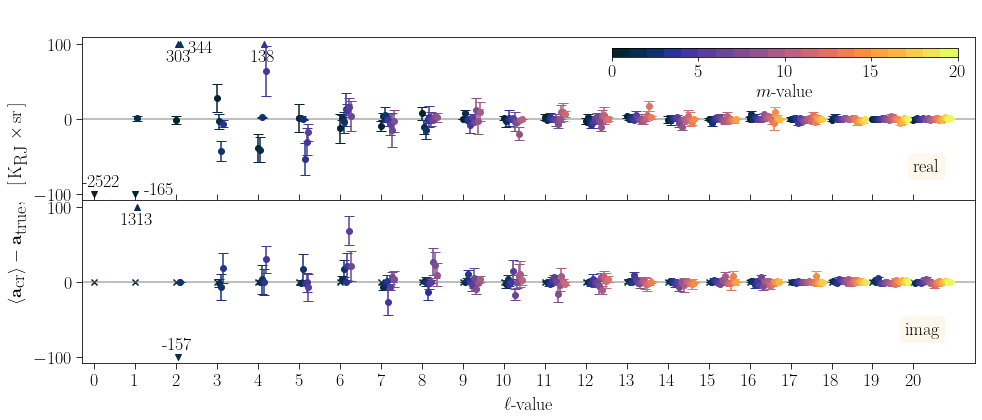

In [31]:
alm_plot(x_true = x_true,
         x_solns = x_solns, 
         lmax = lmax,
         title = r'  ', 
         # ylabel = r'$a_{\ell m}$ mean(estimated) - true',
         ylabel = r'$\langle\mathbf{a}_\textup{cr}\rangle-\mathbf{a}_\textup{true},\,\,\,\,[\,\textup{K}_\textup{RJ}\times\textup{sr}\,]$',
         xlabel = '$\ell$-value',
         filename = 'alms_standard',
         display = True)

### $a_{\ell m}$-plot of true sky +/- 0.1

In [32]:
def a_true_vs_0(x_true, lmax, title, ylabel, xlabel, xlim=None, ylim=None, pdf=True, display = False):
    
    # Choose colours
    cmap20 = discrete_cmap(lmax,cmo.thermal)
    bgcolor = cmap20(16)
    linecolor = '0.5'
    
    # Convert to HEALpy alms for better intuition
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    hp_true = alms2healpy(x_true,lmax)
    hp_zeros = np.zeros_like(hp_true, dtype=np.complex128)

        
    hp_true_re_err = (hp_true.real*0.1)
    
    hp_true_im_err = (hp_true.imag*0.1)
    
    # Move points slightly to better see the different m-modes
    ell_em_labels = [float(ell) for ell in ells]
    em_idx = 0
    for em in ems:
        adjust = em/lmax*0.9
        ell_em_labels[em_idx] += adjust
        em_idx += 1
    
    ## PLOTTING SECTION
    fig, ax = plt.subplots(nrows=2, figsize=(16,6), sharex=True) 
    fig.subplots_adjust(hspace=0)
    
    y_cutoff = 400
    for _ax in ax: 
        _ax.axhline(0,ls="-",color=linecolor, lw=2, alpha=0.5) 
        _ax.set_ylim([-y_cutoff-9,y_cutoff+9])
        _ax.set_xlim([-0.3,21.5])
        _ax.tick_params(length=6)

    # Plotting errorbars, marking out m=0 imag modes and outlier modes.
    outlier_ells_real = []
    ell_idx = 0
    for em in ems:

        # Real part
        if hp_true.real[ell_idx] > y_cutoff:
            real = ax[0].scatter(x=ell_em_labels[ell_idx], y=y_cutoff, 
                                 marker='^', label='imag', color=cmap20(em))
            if np.any(np.isin(outlier_ells_real,ems[ell_idx])):
                ax[0].text(ell_em_labels[ell_idx]+0.2, y_cutoff-5, f'{hp_true.real[ell_idx]:.0f}', va='center', rotation='horizontal')
            else: 
                ax[0].text(ell_em_labels[ell_idx]-0.3, y_cutoff-17, f'{hp_true.real[ell_idx]:.0f}', va='center', rotation='horizontal')
                outlier_ells_real = np.append(outlier_ells_real,ells[ell_idx])
                        
        elif hp_true.real[ell_idx] < -y_cutoff:
            real = ax[0].scatter(x=ell_em_labels[ell_idx], y=-y_cutoff, 
                                  marker='v', label='imag', color=cmap20(em))
            if np.any(np.isin(outlier_ells_real,ems[ell_idx])):
                ax[0].text(ell_em_labels[ell_idx]+0.2, -y_cutoff+5, f'{hp_true.real[ell_idx]:.0f}', va='center', rotation='horizontal')
            else: 
                ax[0].text(ell_em_labels[ell_idx]-0.3, -y_cutoff+17, f'{hp_true.real[ell_idx]:.0f}', va='center', rotation='horizontal')
                outlier_ells_real = np.append(outlier_ells_real,ells[ell_idx])
            
        else:
            real = ax[0].errorbar(x=ell_em_labels[ell_idx], y=hp_true.real[ell_idx], yerr=hp_true_re_err[ell_idx], 
                                  fmt='o', label='real', color=cmap20(em))
                
        ## Imaginary. mark out the m=0 with an X
        if ems[ell_idx] == 0:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=hp_true.imag[ell_idx], 
              marker='x', label='imag', color=cmap20(em))#, color='white')#, markeredgecolor=cmap20(em))
        elif hp_true.imag[ell_idx] > y_cutoff:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=y_cutoff, 
                                 marker='^', label='imag', color=cmap20(em))
            ax[1].text(ell_em_labels[ell_idx]-0.4, y_cutoff-17, f'{hp_true.imag[ell_idx]:.0f}', va='center', rotation='horizontal')
        elif hp_true.imag[ell_idx] < -y_cutoff:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=-y_cutoff, 
                                  marker='v', label='imag', color=cmap20(em))
            ax[1].text(ell_em_labels[ell_idx]-0.4, -y_cutoff+17, f'{hp_true.imag[ell_idx]:.0f}', va='center', rotation='horizontal')
        else:
            imag = ax[1].errorbar(x=ell_em_labels[ell_idx], y=hp_true.imag[ell_idx], yerr=hp_true_im_err[ell_idx], 
                          fmt='o', label='imag', color=cmap20(em))#, markerfacecolor=cmap20(em), markeredgecolor=bgcolor)
        
        ell_idx+=1
        
        
        
        
    # customising ticks
    ax[0].tick_params(bottom=True, direction='inout')
    ax[1].tick_params(top=True, direction='inout')

    ax[0].tick_params(left=True, direction='out')
    ax[1].tick_params(left=True, direction='out')
    
    # Plot labels "real" or "imag"
    ax[0].text(20,-250,r'real', 
         bbox=dict(boxstyle="round",
                      fc=bgcolor, 
                      ec=None, 
                      lw=0, 
                      alpha=0.1))
    
    ax[1].text(19.8,-250,r'imag', 
         bbox=dict(boxstyle="round",
                  fc=bgcolor, 
                  ec=None, 
                  lw=0, 
                  alpha=0.1))
    
    # custom colorbar for m-values
    cax = fig.add_axes([0.585, 0.835, 0.3, 0.02]) #left, bottom, width, height
    norm = mpl.colors.Normalize(vmin=0, vmax=lmax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap20,
                                    norm=norm,
                                    orientation='horizontal')
    cbar.set_label(r'$m$-value')
    
    # title and labels
    ax[0].set_title(title)
    ax[1].set_xlabel(xlabel, labelpad=8)
    fig.text(0.06, 0.5, ylabel, va='center', rotation='vertical')
    ax[1].set_xticks(np.arange(0,lmax+1,1)) # set xticks and labels to be integer and stop at lmax
    # ax[0].set_yscale('log')
    # ax[1].set_yscale('log')
    
    plt.savefig(figpath+'alms_true.pdf')

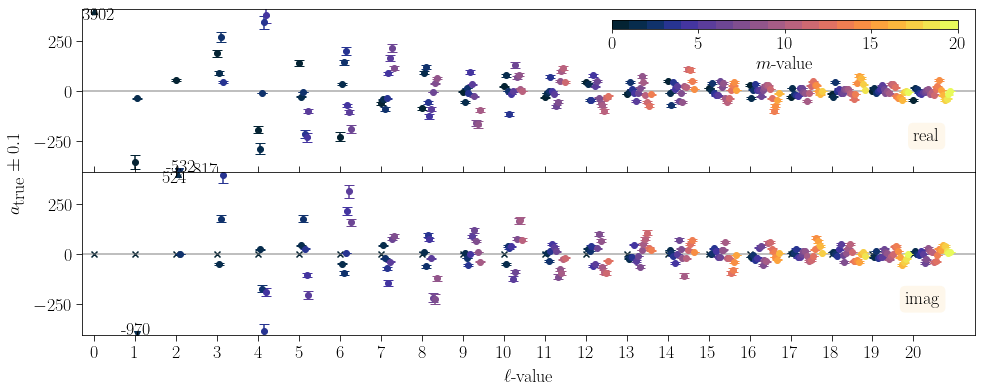

In [33]:
a_true_vs_0(x_true, lmax, title='', ylabel=r'$a_\textup{true}\pm0.1$', xlabel = '$\ell$-value',)

## Averaged $a_{\ell m}$ plot

In [34]:
def get_multiple_results(folder_list, x_solns_ref):

    packed_x_solns = np.zeros([len(folder_list),x_solns_ref.shape[0], x_solns_ref.shape[1]], dtype=np.complex128)
    precomp_times = np.zeros([len(folder_list)])
    total_times = np.zeros([len(folder_list)])
    
    idx = 0    
    for folder in folder_list:
        path = parentpath+folder+'/'
        
        
        _precomp = np.load(path+'precomputed_data.npz')
        precomp_times[idx] = _precomp['precomp_time']
        total_times[idx] = _precomp['total_time']
        
        result_file_list = glob.glob(path+'results_*')
        x_soln_list = np.zeros_like(x_solns_ref)
        
        # Load results and assign
        for filename in result_file_list:
            get_result = np.load(filename)

            # Combine solutions to array
            x_soln_list[get_result['key']] = get_result['x_soln']

        # Collect samples from all folders of interest in one array
        packed_x_solns[idx,:] = x_soln_list
        idx += 1

    avg_precomp_time = np.sum(precomp_times)/len(precomp_times)
    avg_sample_time = np.sum((total_times-precomp_times))/len((total_times-precomp_times))
    avg_total_time = np.sum(total_times)/len(total_times)
    print(f'Times of the runs in:\n\n{folder_list}\n'
          +f'\n min precomputation time:\t {precomp_times.min()} seconds \t in {folder_list[np.argmin(precomp_times)]}'
          +f'\n max precomputation time:\t {precomp_times.max()} seconds \t in {folder_list[np.argmax(precomp_times)]}'
          +f'\n avg precomputation time:\t {avg_precomp_time} seconds\n'
          +f'\n min total sample time:\t\t {(total_times-precomp_times).min()} seconds \t in {folder_list[np.argmin(total_times-precomp_times)]}'
          +f'\n max total sample time:\t\t {(total_times-precomp_times).max()} seconds \t in {folder_list[np.argmax(total_times-precomp_times)]}'
          +f'\n avg total sample time:\t\t {avg_sample_time} seconds\n'
          +f'\n min total time:\t\t {total_times.min()} seconds \t in {folder_list[np.argmin(total_times)]}'
          +f'\n max total time:\t\t {total_times.max()} seconds \t in {folder_list[np.argmax(total_times)]}'
          +f'\n avg total time:\t\t {avg_total_time} seconds\n')
        
    return packed_x_solns


In [35]:
def avg_alm_compare_plot(x_true, x_solns_list, folder_list, color_list, label_list, lmax, log=False, display = False):#, title, , ylabel, xlabel, xlim=None, ylim=None, ):
    
    # Choose colours
    cmap = discrete_cmap(len(folder_list)+1,cmo.phase)
    
    # Convert to HEALpy alms for better intuition
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    hp_true = alms2healpy(x_true,lmax)
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10), sharex=True) 
    fig.subplots_adjust(hspace=0)
    
    label_number = 0
    for x_solns in x_solns_list:
        hp_solns = np.empty((x_solns.shape[0],hp_true.shape[0]),dtype=np.dtype(np.complex128))
        diff = np.empty((x_solns.shape[0],hp_true.shape[0]),dtype=np.dtype(np.complex128))
        idx = 0
        for x_soln in x_solns:
            hp_soln = alms2healpy(x_soln,lmax)
            hp_solns[idx] = hp_soln
            diff[idx] = hp_soln-hp_true
            idx += 1

        diff_mean_real = np.mean(a=diff.real, axis=0) 
        hp_soln_std_real = np.sqrt(np.var(a=hp_solns.real,axis=0))

        # diff_mean_imag = np.mean(a=diff.imag, axis=0) 
        # hp_soln_std_imag = np.sqrt(np.var(a=hp_solns.imag,axis=0))

        delta_l_bar = np.zeros(lmax+1)
        weighted_var = np.zeros(lmax+1)
        
        for ell in np.arange(lmax+1):
            idx = np.where(ells==ell)

            weights = hp_soln_std_real[idx]**(-2)
            normalise = 1#/(ell+1)  #this is actually caught by the weighted mean
            plot_factor = ell*(ell+1)

            delta_l_bar[ell] = plot_factor * normalise * np.sum(weights*diff_mean_real[idx])/(np.sum(weights))
            weighted_var[ell] = plot_factor * 1/np.sum(weights)

        if log: 
            delta_l_plot = np.abs(delta_l_bar)
        else: 
            delta_l_plot = delta_l_bar
            
            
        ax[0].plot(np.arange(lmax+1),
                    delta_l_plot,
                    '.-',
                    label=label_list[label_number],
                    color=color_list[label_number])
        ax[1].plot(np.arange(lmax+1),
            weighted_var,
            '.-',
            label=label_list[label_number],
            color=color_list[label_number])
        label_number += 1

        
    ax[1].set_xlabel(r'$\ell$-value')
    # ax.set_ylabel(r'$<\textup{mean}(\textup{estimate}) - \textup{true}>_{m}$')
    ax[0].set_ylabel(r'$\ell(\ell+1)\,\overline{\Delta}_{\ell}$')
    ax[1].set_ylabel(r'$\ell(\ell+1)\,\overline{\sigma}_{\ell}^2$')
    # ax[1].set_yscale('log')
    if log: [_ax.set_yscale('log') for _ax in ax]
    # set xticks and labels to be integer and stop at lmax
    ax[1].set_xticks(np.arange(0,lmax+1,1)) 
    [_ax.grid(color='0.95') for _ax in ax]
    # ax.set_ylim([-10,10])
    
    # Fixing the order of the labels
    ax[0].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5,frameon=False)#*([ label[i] for i in [1,0] ] for label in plt.gca().get_legend_handles_labels()), loc='best')
    
    plt.savefig(figpath+'avg_alm'+'.pdf',
                bbox_inches='tight',
                transparent=False,
                dpi=300)#fig.dpi)

    if display == False:
        plt.close()
                                   

In [36]:
[file[62:] for file in sorted(glob.glob(parentpath+'*'))]

['10000_prior_only',
 '10000_times_prior',
 '1000_prior_only',
 '1000_times_prior',
 '100_prior_only',
 '100_times_prior',
 '10_prior_only',
 '10_times_prior',
 '4m_beam',
 '4m_beam_noise_times_100',
 'README.md',
 'a_0_zero_noise_100',
 'a_0_zero_noise_10000',
 'a_0_zero_noise_std',
 'beam_3m_mwa_like',
 'beam_3m_mwa_like_N_1e-01',
 'beam_3m_mwa_like_N_1e-02',
 'beam_3m_mwa_like_prior_only',
 'bl_100m_east',
 'bl_100m_east_lmax30',
 'bl_100m_north',
 'bl_100m_north_lmax30',
 'cart_view',
 'load_and_plot.ipynb',
 'lst_0_16_steps_20',
 'lst_0_8_steps_20',
 'lst_16_24',
 'lst_8_16',
 'noise_10000_inv_prior_zero',
 'noise_10000_prior_std',
 'noise_100_inv_prior_zero',
 'noise_100_prior_std',
 'noise_1e-01_prior_std',
 'noise_1e-02_prior_std',
 'noise_half_prior_std',
 'noise_std_inv_prior_zero',
 'noise_times_10',
 'noise_times_100',
 'prior_10000_noise_std_mean_std',
 'prior_100_mean_std',
 'prior_only',
 'prior_only_lmax30',
 'standard',
 'standard_4000',
 'standard_lmax30',
 'standard_

In [37]:
# change this manually depending on what you're interested in comparing
folder_list = [
    'standard',
    # 'standard_4000',
    'standard_lmax30',
    # '4m_beam',
    # '4m_beam_noise_times_100',
    # 'a_0_zero_noise_100',
    # 'a_0_zero_noise_10000',
    # 'a_0_zero_noise_std',
    'bl_100m_east',
    'bl_100m_east_lmax30',
    'bl_100m_north',
    'bl_100m_north_lmax30',
    'lst_0_16_steps_20',
    'lst_0_8_steps_20',
    'lst_16_24',
    'lst_8_16',
    # 'noise_10000_inv_prior_zero',
    # 'noise_100_inv_prior_zero',
    # 'noise_10000_prior_std',
    # 'noise_100_prior_std',
    # 'noise_times_10',
    # 'noise_times_100',
    # 'prior_10000_noise_std_mean_std',
    # 'prior_100_mean_std',
    # 'prior_only',
    # 'prior_only_lmax30',
              ]

# x_solns_list = get_multiple_results(folder_list, x_solns_ref=x_solns)

In [38]:
label_list = [
    'Standard',
    r'$\ell_\textup{max}=30$',
    # '4m_beam',
    # '4m_beam_noise_times_100',
    # r'$\mathbf{a}_0=0$, $\mathbf{N}\times 10^2$',
    # r'$\mathbf{a}_0=0$, $\mathbf{N}\times 100^2$',
    # r'$\mathbf{a}_0=0$, $\mathbf{N} =$ standard',
    r'$+1$ ant: $100$ m E, $\ell_\textup{max}=20$',
    r'$+1$ ant: $100$ m E, $\ell_\textup{max}=30$',
    r'$+1$ ant: $100$ m N, $\ell_\textup{max}=20$',
    r'$+1$ ant: $100$ m N, $\ell_\textup{max}=30$',
    r'20 LSTs in: $0-16$ hr',
    r'20 LSTs in: $0-8$ hr',
    r'10 LSTs in: $16-24$ hr',
    r'10 LSTs in: $8-16$ hr',
    # r'$\mathbf{N}\times 100^2$, $\mathbf{S}^{-1}=0$',
    # r'$\mathbf{N}\times 10^2$,\,\,\, $\mathbf{S}^{-1}=0$',
    # r'$\mathbf{N}\times 100^2$, $\mathbf{S} =$ standard',
    # r'$\mathbf{N}\times 10^2$,\,\,\, $\mathbf{S} =$ standard',
    # 'noise_times_10',
    # 'noise_times_100',
    # r'$\mathbf{S} \times 100^2$, $(\mathbf{N},a_0) =$ standard',
    # r'$\mathbf{S} \times 10^2$,\,\,\, $(\mathbf{N},a_0) =$ standard',
    # 'prior_only',
    # 'prior_only_lmax30',
              ]

In [39]:
color_list = [
    'black',
    'gray',
    'lightcoral',
    'firebrick',
    # 'maroon',
    'gold',
    'darkgoldenrod',
    # 'peru',
    # 'skyblue',
    # 'steelblue',
    'darkseagreen',
    'forestgreen',
             ]

In [40]:
# avg_alm_compare_plot(x_true, x_solns_list, folder_list, color_list, label_list, lmax, display=True, log=True)

## z-score histogram plot

<ipython-input-8-eca0c14d5bf6>:20: RuntimeWarning: invalid value encountered in true_divide
  z_score_imag = (hp_soln_mean_imag - hp_true.imag)/hp_soln_std_imag


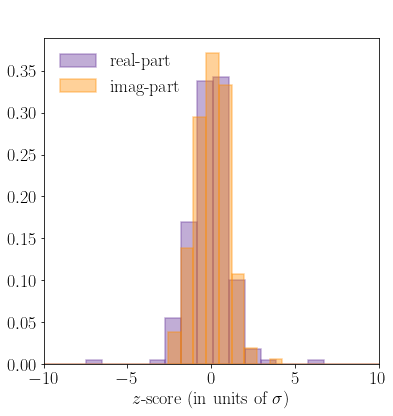

In [41]:
z_score_histogram(x_true = x_true,
                     x_solns = x_solns, 
                     lmax = lmax,
                     title = ' ', 
                     ylabel = r'$z$-score count',
                     xlabel = r'$z$-score (in units of $\sigma$)',
                     xlim = [-10,10],
                     filename = 'z_order_histogram',
                     display = True)

## Plotting subset of solution maps

0.0 180.0 -180.0 180.0
<ipython-input-9-44692ccfdd72>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels)


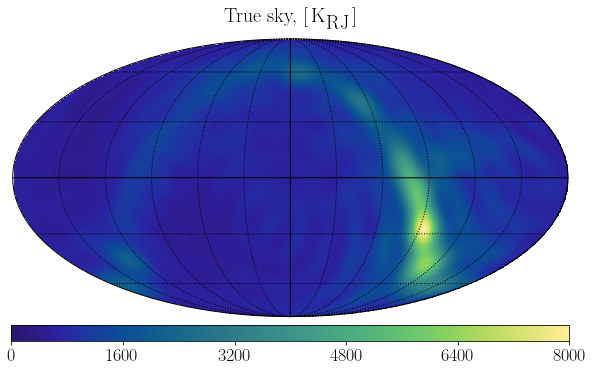

In [42]:
# True map
map_x_true = hp.alm2map(alms2healpy(x_true,lmax),nside)
# map_x_true_filter = hp.alm2map(high_pass_filter*alms2healpy(x_true,lmax),nside)
map_vmin = np.floor(map_x_true.min()/10)*10
map_vmax = np.ceil(map_x_true.max()/10)*10
map_plot(map_x_true, 
         r'True sky,\,\,$[\,\textup{K}_\textup{RJ}\,]$', 
         figpath+'map_x_true',
         0,#map_vmin, 
         8000,#map_vmax,
         display=True,
         pdf=True)

In [43]:
# Solution maps
maps = np.array([hp.alm2map(alms2healpy(x_soln, lmax),nside) for x_soln in x_solns])

In [44]:
if not os.path.isdir(figpath+'soln_maps/'): os.makedirs(figpath+'soln_maps/')
key_ = 0
for map_x_soln in maps[:4]:
    map_plot(map_x_soln, fr'$x_\textup{{soln,{key_}}}$ ', figpath+'soln_maps/'+f'map_x_soln_{key_}', map_vmin, map_vmax, pdf=False)
    key_ += 1

0.0 180.0 -180.0 180.0
<ipython-input-9-44692ccfdd72>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels)
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


## Antenna positions

`ant_pos` file was read and antennas plotted


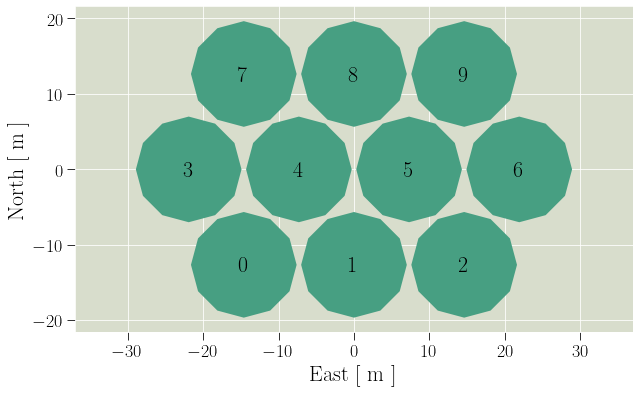

In [45]:
# Not all folders have this file, as it was changed
if os.path.isfile(path+'ant_pos.npz'):
    print('`ant_pos` file was read and antennas plotted')
else:
    print('`ant_pos` file doesnt exist. 10 ants in (3,4,3) structure assumed')

plot_ants(ant_pos=ant_pos,
      file_name=figpath+'ant_pos',
      display=True)

In [46]:
dict_ants = dict(ant_pos)
print(np.linalg.norm(dict_ants['0']-dict_ants['1']))
print(np.linalg.norm(dict_ants['0']-dict_ants['7']))
print(np.linalg.norm(dict_ants['0']-dict_ants['8']))
print(np.linalg.norm(dict_ants['0']-dict_ants['9']))
print(np.linalg.norm(dict_ants['3']-dict_ants['6']))

min_distance = np.linalg.norm(dict_ants['0']-dict_ants['1'])
lmin_allowed = (np.pi*min_distance)/(2.998*1e8/freqs[0])
print(f'the lowest lmax that is allowed is: {lmin_allowed}')

max_distance = np.linalg.norm(dict_ants['3']-dict_ants['6'])
lmax_allowed = (np.pi*max_distance)/(2.998*1e8/freqs[0])
print(f'the highest lmax that is allowed is: {lmax_allowed}')

14.6
25.287941790505606
29.2
38.62796914154302
43.8
the lowest lmax that is allowed is: 15.299283769983647
the highest lmax that is allowed is: 45.89785130995094


### Baseline length vs $\ell$-values

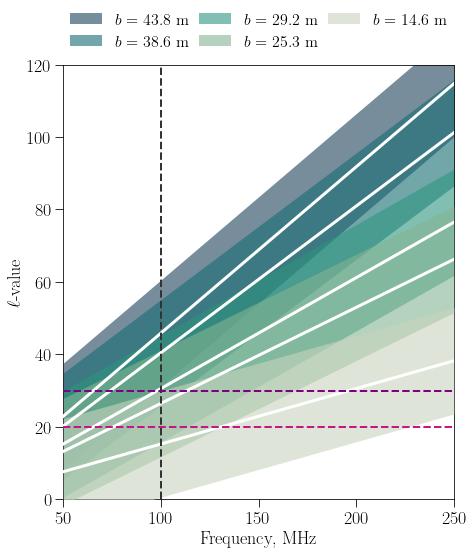

In [47]:
beam_diameter = 14.                  # m
speed_of_light = 2.998e08            # m/s
fwhm_rad = speed_of_light/(freqs[0]*beam_diameter)  # radian 
fwhm_deg = np.rad2deg(fwhm_rad)
freq_list = np.linspace(50,250,100)

# The errorbar \delta \ell \simeq np.pi / FWHM(rad) 
delta_ell = np.pi/fwhm_rad 

bl_lengths = np.array([np.linalg.norm(dict_ants['0']-dict_ants['1']), # meters
                       np.linalg.norm(dict_ants['0']-dict_ants['7']),
                       np.linalg.norm(dict_ants['0']-dict_ants['8']),
                       np.linalg.norm(dict_ants['0']-dict_ants['9']),
                       np.linalg.norm(dict_ants['3']-dict_ants['6'])])

   
fig, ax = plt.subplots(ncols=1, figsize=(7,8)) 
cmap5 = discrete_cmap(5, cmocean.tools.crop_by_percent(cmo.tempo_r, 30, which='both', N=None))
for i, bl in enumerate(np.flip(bl_lengths)):
    ell_measured = np.pi * bl /(speed_of_light/freq_list)*1e06
    ax.fill_between(freq_list, ell_measured-delta_ell, ell_measured+delta_ell, alpha=0.6, color=cmap5(i), linewidth=0, zorder = i,  label=r'$b=$'+f' {bl:.1f} m')
    ax.plot(freq_list, ell_measured, color='white', zorder = 100+i, lw=3)

ax.axvline(100+0.1,ls="--",color='0.2',lw=2, zorder = 200)  # b (nlsts) 
ax.axhline(20,ls='--', lw=2, color='mediumvioletred', zorder = 200)
ax.axhline(30,ls='--', lw=2, color='purple', zorder = 200)
  
# ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, frameon=False, title='Baseline length')
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", #title='Baseline length',
               mode="expand", borderaxespad=0, ncol=3,frameon=False, fontsize=16)


plt.xlabel('Frequency, MHz')
plt.ylabel(r'$\ell$-value')
ax.set_xlim([freq_list[0],freq_list[-1]])
ax.set_ylim([0,120])
ax.tick_params(length=8)

fig.savefig(figpath+'baseline_vs_ell'+'.pdf', 
        bbox_inches='tight', 
        transparent=False, 
        dpi=300,#fig.dpi,
        facecolor='white')

## Plot the standard deviation of the solutions

0.0 180.0 -180.0 180.0
<ipython-input-10-04631b99016b>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels)


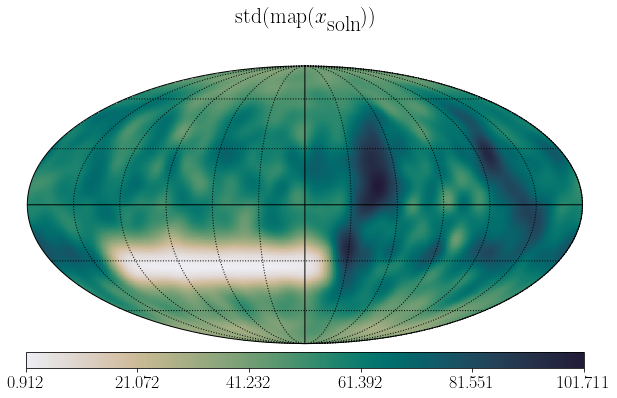

In [48]:
var = np.var(a=maps,axis=0)
std = np.sqrt(var)

# Plot!
title = r'std(map($x_\textup{soln}$))'+'\n'#+r'10000 $\times$ prior variance'
std_plot(std, title, figpath+f'std_x_solns', display=True)

In [49]:
observed_sky = (2*12.3*(120+2*12.3))
full_sky = (4*np.pi*(180/np.pi)**2)
(observed_sky)/full_sky*100

8.622799169477984

## The mean of the realisations

0.0 180.0 -180.0 180.0


-940.8569462699686


<ipython-input-9-44692ccfdd72>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels)


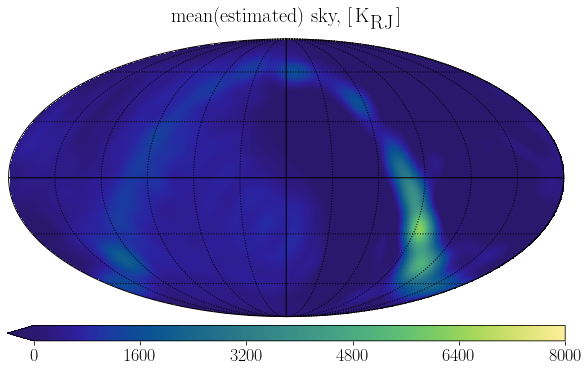

In [50]:
mean = np.mean(a=maps, axis=0)
print(mean.min())
map_plot(skymap = mean,
         title = r'mean(estimated) sky,\,\,$[\,\textup{K}_\textup{RJ}\,]$',
         file_name = figpath+'mean_x_solns',
         vmin = 0,#map_vmin, 
         vmax = 8000,#map_vmax, 
         display = True)

### Residuals!

0.0 180.0 -180.0 180.0
<ipython-input-13-076993222bb2>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels, fontsize='20')


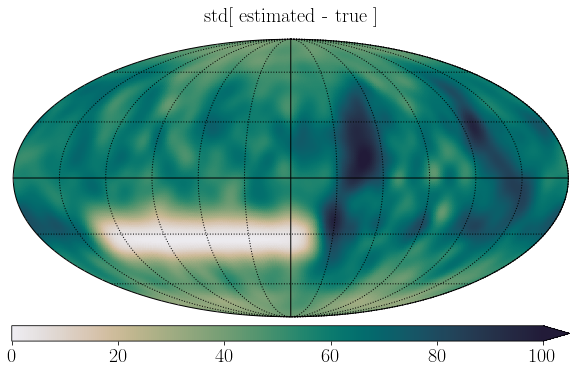

In [51]:
compare_map(skymap = np.sqrt(np.var(a=maps-map_x_true,axis=0)),#compare_mean.max(), 
                 # title = r' std[ (data+prior) - true ]',#'$_{\textup{normalised}}$', 
                 title = r' std[ estimated - true ]',#'$_{\textup{normalised}}$', 
                 file_name = figpath+f'residual_std', 
                 vmin = 0, 
                 vmax = 100,
                 cmap = cmo.rain,
                 display = True)

0.0 180.0 -180.0 180.0


5.5224652240296495 -0.07678528366769052


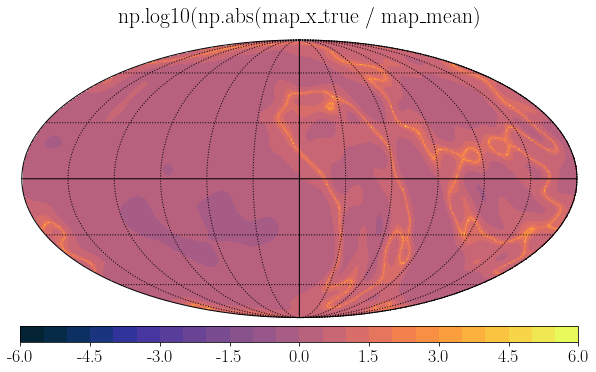

In [52]:
residual_div = (map_x_true / mean)

discrete_log_map(residual_map = residual_div, 
                 title = 'np.log10(np.abs(map_x_true / map_mean)', 
                 file_name = figpath+'residual_div', 
                 mapmin = -6, 
                 mapmax = 6,
                 display = True)



### Compare to other solutions (CHOOSE FOLDER)

In [53]:
# Display available folders
parentpath = '/home/katgla/Documents/hera/vis_and_rotations/data_dirac_runs/'
[file[62:] for file in sorted(glob.glob(parentpath+'*'))]

['10000_prior_only',
 '10000_times_prior',
 '1000_prior_only',
 '1000_times_prior',
 '100_prior_only',
 '100_times_prior',
 '10_prior_only',
 '10_times_prior',
 '4m_beam',
 '4m_beam_noise_times_100',
 'README.md',
 'a_0_zero_noise_100',
 'a_0_zero_noise_10000',
 'a_0_zero_noise_std',
 'beam_3m_mwa_like',
 'beam_3m_mwa_like_N_1e-01',
 'beam_3m_mwa_like_N_1e-02',
 'beam_3m_mwa_like_prior_only',
 'bl_100m_east',
 'bl_100m_east_lmax30',
 'bl_100m_north',
 'bl_100m_north_lmax30',
 'cart_view',
 'load_and_plot.ipynb',
 'lst_0_16_steps_20',
 'lst_0_8_steps_20',
 'lst_16_24',
 'lst_8_16',
 'noise_10000_inv_prior_zero',
 'noise_10000_prior_std',
 'noise_100_inv_prior_zero',
 'noise_100_prior_std',
 'noise_1e-01_prior_std',
 'noise_1e-02_prior_std',
 'noise_half_prior_std',
 'noise_std_inv_prior_zero',
 'noise_times_10',
 'noise_times_100',
 'prior_10000_noise_std_mean_std',
 'prior_100_mean_std',
 'prior_only',
 'prior_only_lmax30',
 'standard',
 'standard_4000',
 'standard_lmax30',
 'standard_

In [54]:
prior_file = True
if prior_file:
    # For comparison to the prior-only case (or vice versa, but then change this!)
    prior_path = parentpath+'prior_only/'
    prior_file_list = glob.glob(prior_path+'results_*')

    # Allocate arrays
    prior_x_solns = np.empty((len(prior_file_list),len(key_file['x_soln'])),dtype=np.dtype(np.complex128))

    # Load results and assign
    for filename in prior_file_list:
        prior_result = np.load(filename)

        # Combine solutions to array
        key = prior_result['key']
        prior_x_soln = prior_result['x_soln']
        prior_x_solns[key] = prior_x_soln

    # Solution maps
    prior_maps = np.array([hp.alm2map(alms2healpy(prior_x_soln, lmax),nside) for prior_x_soln in prior_x_solns])
    prior_mean = np.mean(a=prior_maps, axis=0)

0.0 180.0 -180.0 180.0
<ipython-input-9-44692ccfdd72>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels)
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


3.199749549984019 -2.6125032393764602


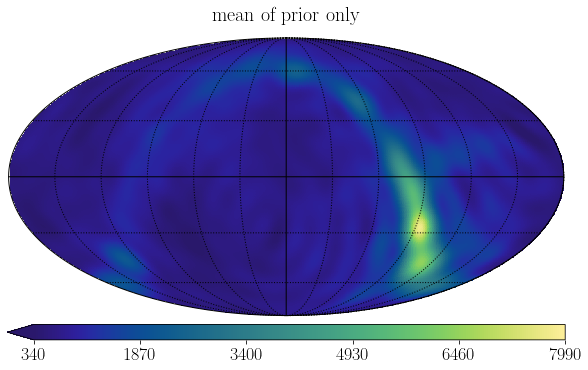

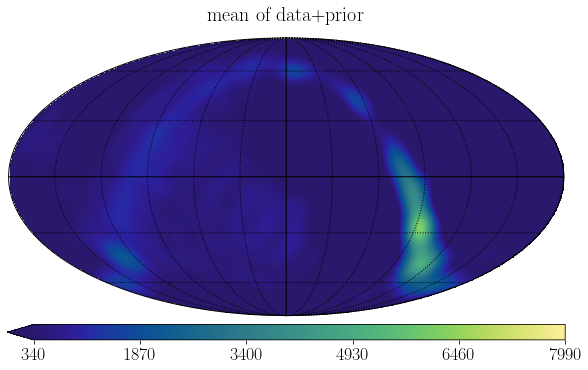

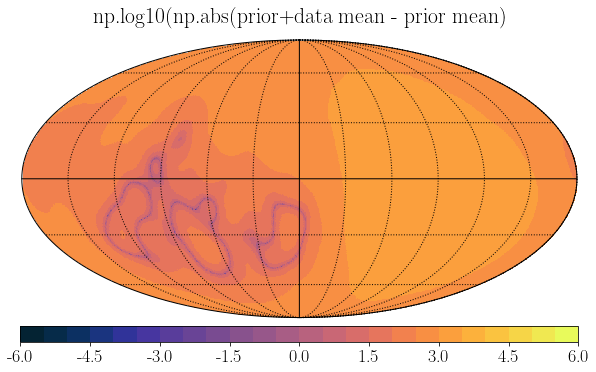

In [55]:
if prior_file:
    map_plot(prior_mean, title='mean of prior only', file_name=figpath+'mean_prior_only.png',display=True,vmin=map_vmin, vmax=map_vmax)
    map_plot(mean,title='mean of data+prior', file_name=figpath+'test.png',display=True,vmin=map_vmin, vmax=map_vmax)

    discrete_log_map(residual_map = mean-prior_mean, 
                     title = 'np.log10(np.abs(prior+data mean - prior mean)', 
                     file_name = figpath+'residual_sub_Test', 
                     mapmin = -6, 
                     mapmax = 6,
                     display = True)

0.0 180.0 -180.0 180.0
<ipython-input-13-076993222bb2>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels, fontsize='20')
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


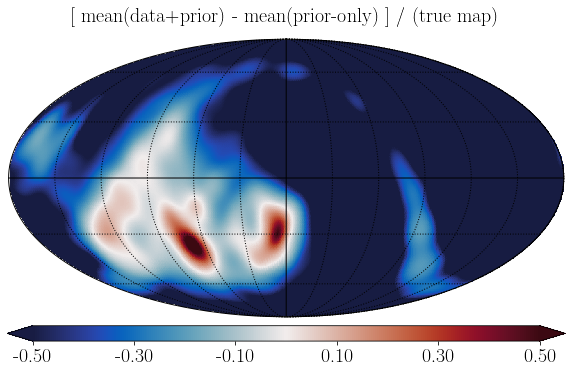

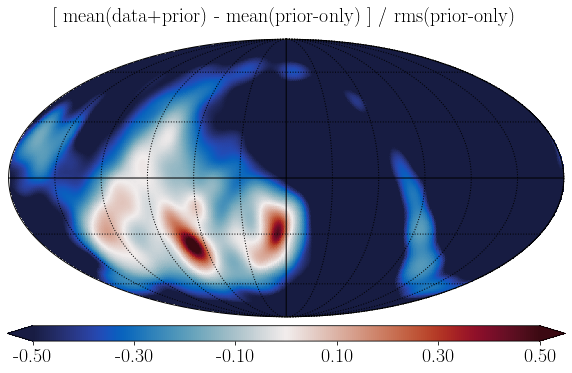

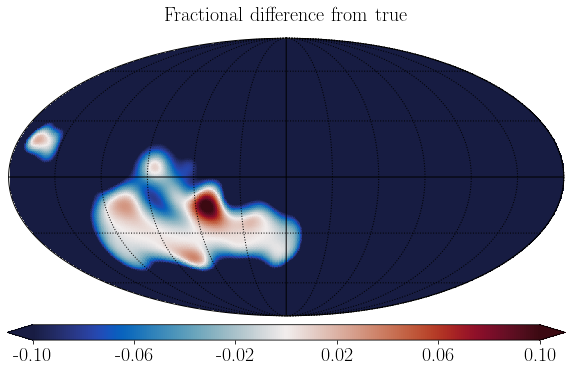

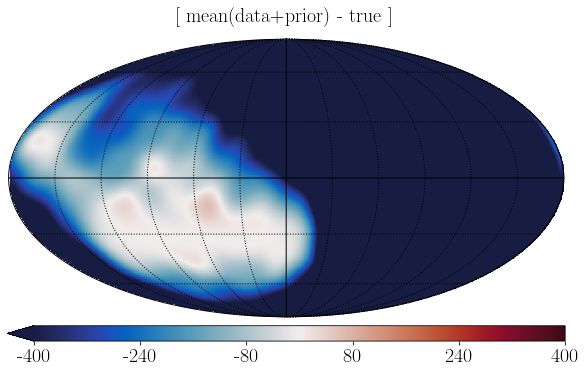

In [56]:
if prior_file:
    difference = (mean-prior_mean)

    compare_map(skymap = difference/prior_mean,#/map_x_true,
                     title = r' [ mean(data+prior) - mean(prior-only) ]'+' / (true map)',#'$_{\textup{normalised}}$', 
                     file_name = figpath+f'residual_compare_sub', 
                     vmin = -0.5, 
                     vmax = 0.5,
                     display = True)

    prior_rms = np.sqrt(np.mean(a=(prior_maps**2), axis=0))

    compare_map(skymap = difference/prior_rms, 
                     title = r' [ mean(data+prior) - mean(prior-only) ]'+' / rms(prior-only)',#'$_{\textup{normalised}}$', 
                     file_name = figpath+f'residual_compare_rms', 
                     vmin = -0.5, 
                     vmax = 0.5,
                     # cmap = cmo.tarn,
                     display = True)

    # compare_rms = np.sqrt(np.mean(a=(compare_maps**2), axis=0))


compare_map(skymap = (mean-map_x_true)/map_x_true,
            # title = 'Fractional difference from true',
            # title = r' [ mean(data+prior) - true ]'+' / (true)',#'$_{\textup{normalised}}$', 
            title = r'Fractional difference from true',#[ mean(estimated) - true ]'+' / (true)',#'$_{\textup{normalised}}$', 
            file_name = figpath+f'residual_mean_true_normalised', 
            vmin = -0.1, 
            vmax = 0.1,
            # cmap = cmo.delta,
            pdf = True,
            display = True)

compare_map(skymap = (mean-map_x_true),#compare_mean.max(), 
            title = r' [ mean(data+prior) - true ]',#'$_{\textup{normalised}}$', 
            file_name = figpath+f'residual_mean_true', 
            vmin = -400,#-2000, 
            vmax = 400,#2000,
            cmap = cmo.balance,
            display = True)



### Cartesian view focused on beam region

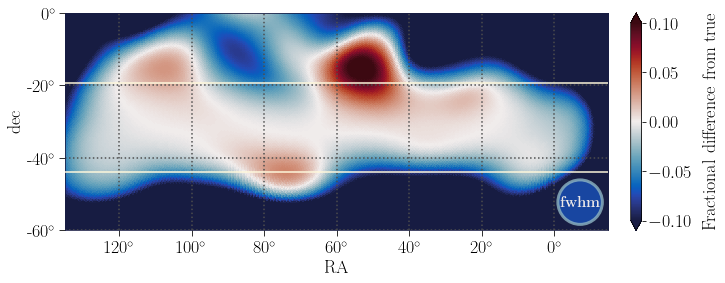

In [57]:
# Plot the fwhm of the beam in the corner
lsts_deg = ((lsts_hours/24)*360)
lonra=[lsts_deg.min()-15,lsts_deg.max()+15] # RA
latra=[-60,0]#[-31.7-fwhm_deg,-31.7+fwhm_deg]     # dec

cartplot = hp.cartview(map=(mean-map_x_true)/map_x_true, lonra=lonra, latra=latra, return_projected_map=True, cmap = cmo.balance)
plt.close()

fig, ax = plt.subplots(ncols=1,figsize=(20,4))
im = plt.imshow((cartplot),
           origin='lower',
           extent=(lonra[1],lonra[0],latra[0],latra[1]), 
           interpolation = 'none',
           cmap = cmo.balance, 
           vmin=-0.1, vmax=0.1)

grid_spacing = 20
custom_grid_on = True

if custom_grid_on:
    # Create grid lines for every 30 degrees
    lon_range = np.arange(lonra[0],lonra[1])
    lon_lines = lon_range[np.where([i.is_integer() for i in lon_range/grid_spacing])]

    lat_range = np.arange(latra[0],latra[1])
    lat_lines = lat_range[np.where([i.is_integer() for i in lat_range/grid_spacing])]
    
    # make 0 degrees a darker line
    for line in lat_lines:
        # if line == 0:
            # plt.axhline(line,ls=":",color="white")
        # else:
            plt.axhline(line,ls=":",color="0.3")
    for line in lon_lines:
        # if line == 0:
            # plt.axvline(line,ls=":",color="white")
        # else:
            plt.axvline(line,ls=":",color="0.3")
    
    # Set tick marks to match grid spacing
    ax.xaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
else:
    plt.grid(color='black', ls=':')        
            
cbar = plt.colorbar(extend='both', pad=0.02)#location='top', aspect=35, pad=0.03)
cbar.set_label('Fractional difference from true', labelpad=10)

ax.xaxis.set_major_formatter('{x:.0f}'r'$^\circ$')
ax.yaxis.set_major_formatter('{x:.0f}'r'$^\circ$')
ax.tick_params(length=6)

plt.xlabel('RA')
plt.ylabel('dec')

circ = mpl.patches.Circle(xy = (lonra[0]+7.8, latra[0]+7.8), 
                          radius = fwhm_deg/2, 
                          alpha = 0.8,
                          edgecolor = '#8fb5c2',
                          facecolor = '#1951ba',
                          linewidth = 3,
                          fill=True,
                          zorder=10)

ax.add_patch(circ)
annotate = ax.annotate(r'\textbf{fwhm}', xy=(lonra[0]+13.3, latra[0]+6.6), xycoords='data', color='#eae7e7', zorder=10,fontsize=15)

ax.axhline(-31.7+fwhm_deg, color='cornsilk', zorder=10)
ax.axhline(-31.7-fwhm_deg, color='cornsilk', zorder=10)

ax.spines[:].set_color(cmo.balance(0))

fig.savefig(figpath+'difference_cartesian'+'.pdf', 
            bbox_inches='tight', 
            transparent=False, 
            dpi=300,#fig.dpi,
            facecolor='white')

# np.mean(np.abs(cartplot))

In [58]:
fwhm_deg

12.269481927158628

## Cartesian view multiple

-2 0


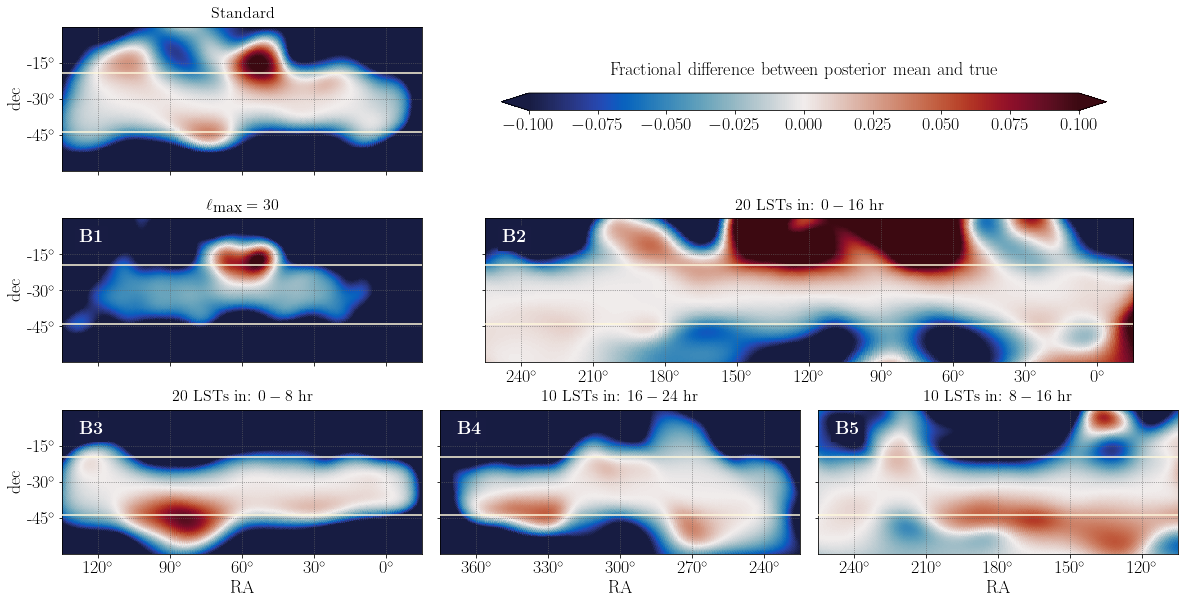

In [59]:
change_plot_order = (np.array([0,1,6,7,8,9]),) #0,1,7,6,4,2,8,5,3,9
cartplot_multiple(np.array(folder_list)[change_plot_order],
                  np.array(label_list)[change_plot_order],
                  nside)

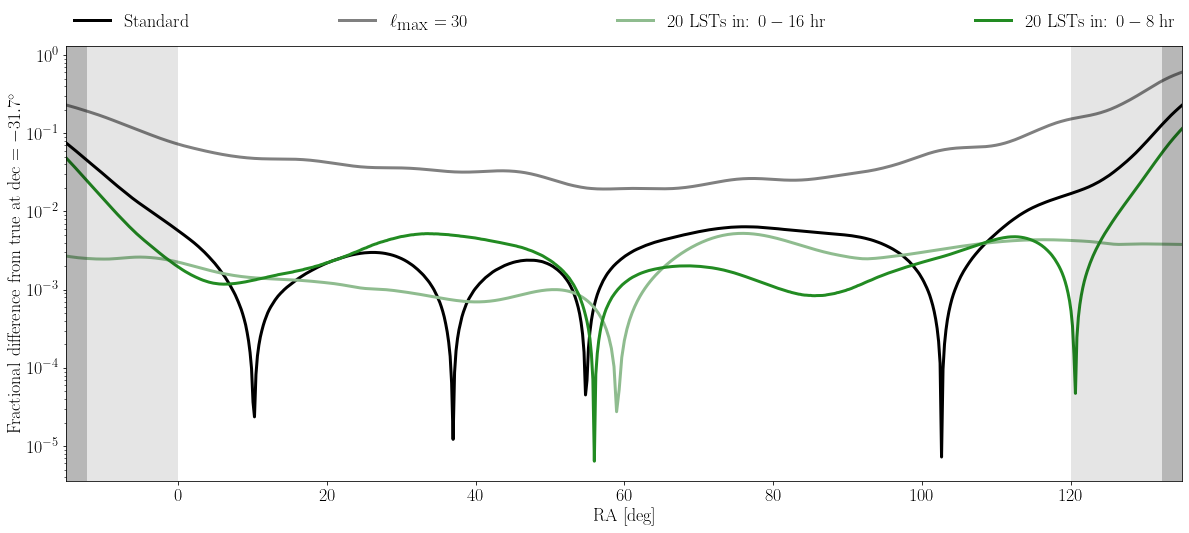

In [60]:
change_plot_order = (np.array([0,1,6,7]),)
cartplot_slice(folder_list = np.array(folder_list)[change_plot_order],#[(np.array([0,1]),)],
               x_true = x_true,
               label_list = np.array(label_list)[change_plot_order],#[(np.array([0,1]),)],
               color_list = np.array(color_list)[change_plot_order],#[change_plot_order],#[(np.array([0,1]),)],
               nside=nside) 

# change_plot_order = (np.array([9,6]),)
# cartplot_slice(folder_list = np.array(folder_list)[change_plot_order],#[(np.array([0,1]),)],
#                x_true = x_true,
#                label_list = np.array(label_list)[change_plot_order],#[(np.array([0,1]),)],
#                color_list = np.array(color_list),#[(np.array([0,1]),)],
#                nside=nside, show_fwhm=False) 

## 2D power spectrum

Text(0.5, 1.0, 'Tapered data and B-H window contour')

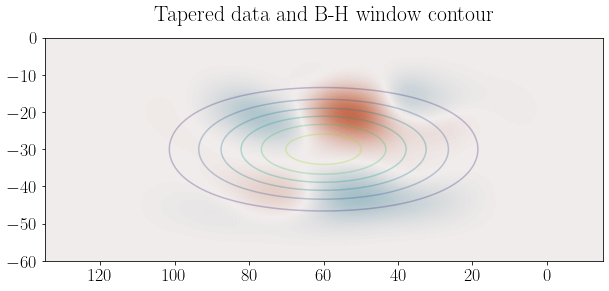

In [61]:
window_dec = signal.windows.blackmanharris(cartplot.shape[0])
window_ra = signal.blackmanharris(cartplot.shape[1])
window_2d = window_dec[:,np.newaxis] * window_ra[np.newaxis,:]

tapered_data = window_2d * cartplot

fig, ax = plt.subplots(ncols=1,figsize=(10,8))
ax.contour(window_2d,alpha=0.3,extent=(lonra[1],lonra[0],latra[0],latra[1]))
ax.imshow(tapered_data,origin='lower',extent=(lonra[1],lonra[0],latra[0],latra[1]), cmap=cmo.balance, vmin=-0.10,vmax=0.10)
ax.set_title('Tapered data and B-H window contour')

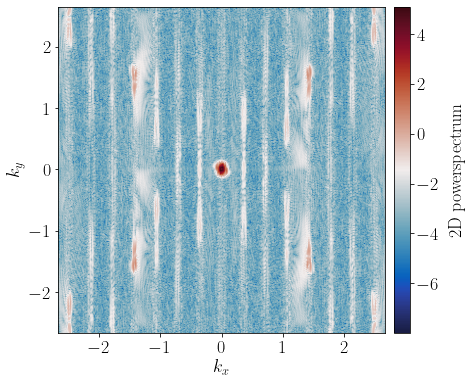

In [62]:
fft_data = fft2(tapered_data)
pspec_2d = fftshift(fft_data.conj() * fft_data)

# get wavenumbers for each direction
npix_dec = tapered_data.shape[0]
npix_ra = tapered_data.shape[1]
d_dec = (latra[1]-latra[0])/npix_dec
d_ra = (lonra[1]-lonra[0])/npix_ra

k_y = fftshift(fftfreq(npix_dec, d_dec)) # deg^-1
k_x = fftshift(fftfreq(npix_ra, d_ra))    # deg^-1

fig, ax = plt.subplots(ncols=1,figsize=(8,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
im1 = plt.imshow(np.log10(np.abs(pspec_2d)),
                 origin='lower', 
                 extent=[k_x[0],k_x[-1],k_y[0],k_y[-1]],
                 # vmin=-4,
                 # vmax=4,
                 cmap=cmo.balance)

ax.set_ylabel(r'$k_y$')
ax.set_xlabel(r'$k_x$')

cbar = plt.colorbar(pad=0.02)
cbar.set_label('2D powerspectrum', labelpad=10)

## 1D powerspectrum

Text(0, 0.5, '1d pspec')

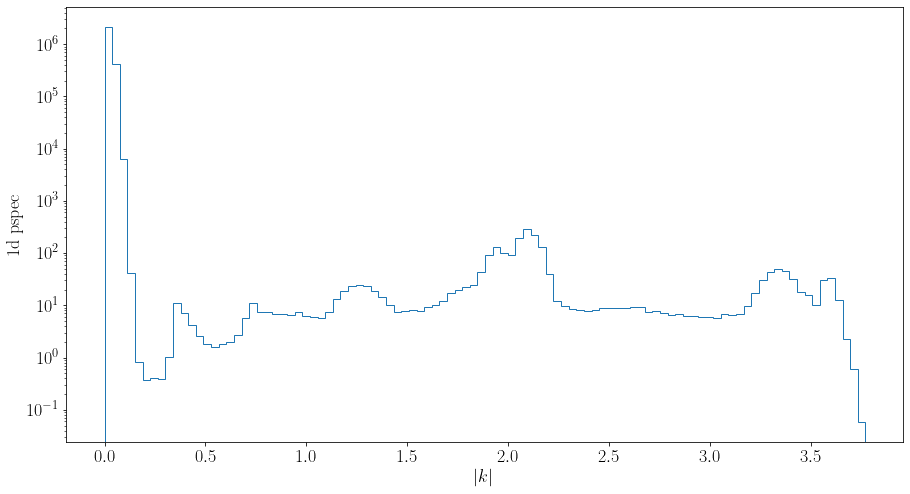

In [63]:
idx = 0
p_k = np.zeros((2, k_x.size*k_y.size))
for i in range(k_x.size):
    for j in range(k_y.size):
        k = np.sqrt(k_x[i]**2 + k_y[j]**2)

        p_k[0,idx] = k
        p_k[1,idx] = pspec_2d[j,i].real
        idx += 1

plt.figure(figsize=(15,8))
hist = plt.hist(x=(p_k[0,:]), bins=100, weights=p_k[1,:].real, log=True, histtype='step')
plt.xlabel(r'$|k|$')
plt.ylabel('1d pspec')

## Power spectra multiple (2D) 

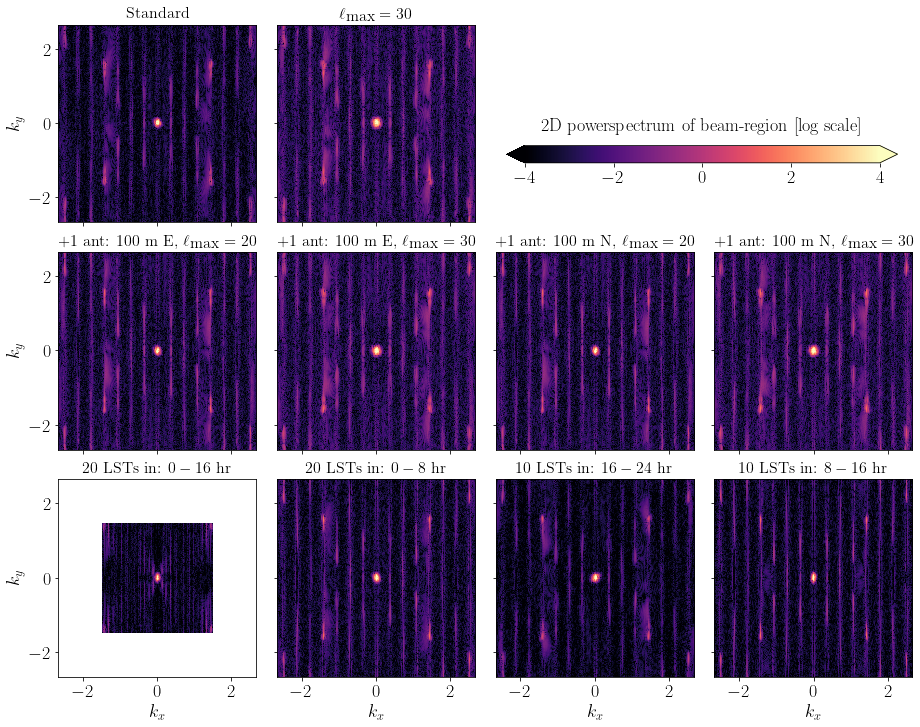

In [64]:
pspec_multiple(folder_list, label_list, nside, vmin_2d=-4,vmax_2d=4)

## Covariance matrix, correlation matrix

<ipython-input-19-db0a92a649e3>:165: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-19-db0a92a649e3>:166: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


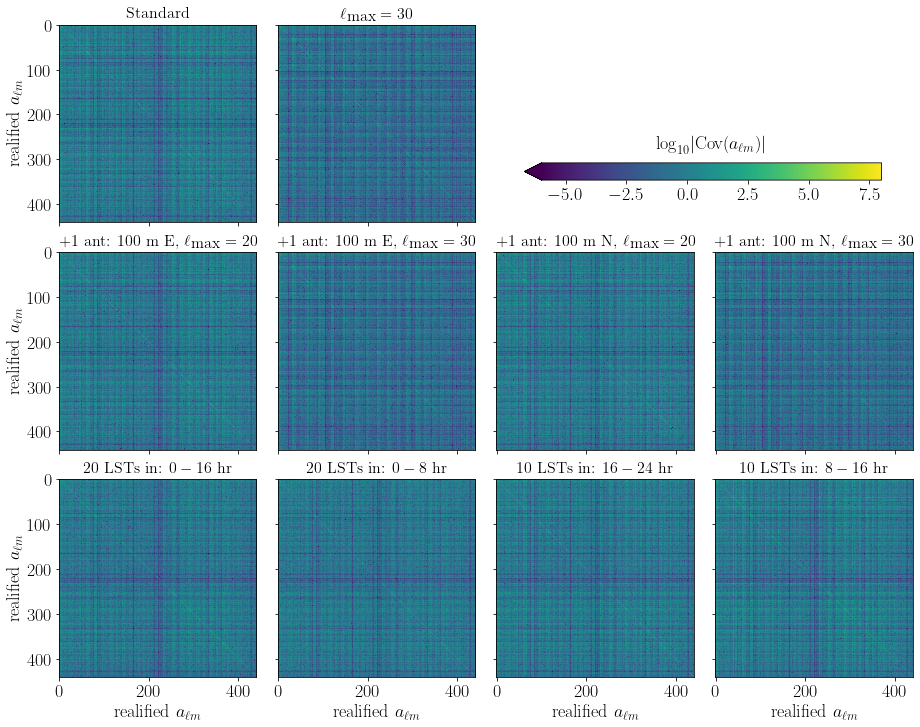

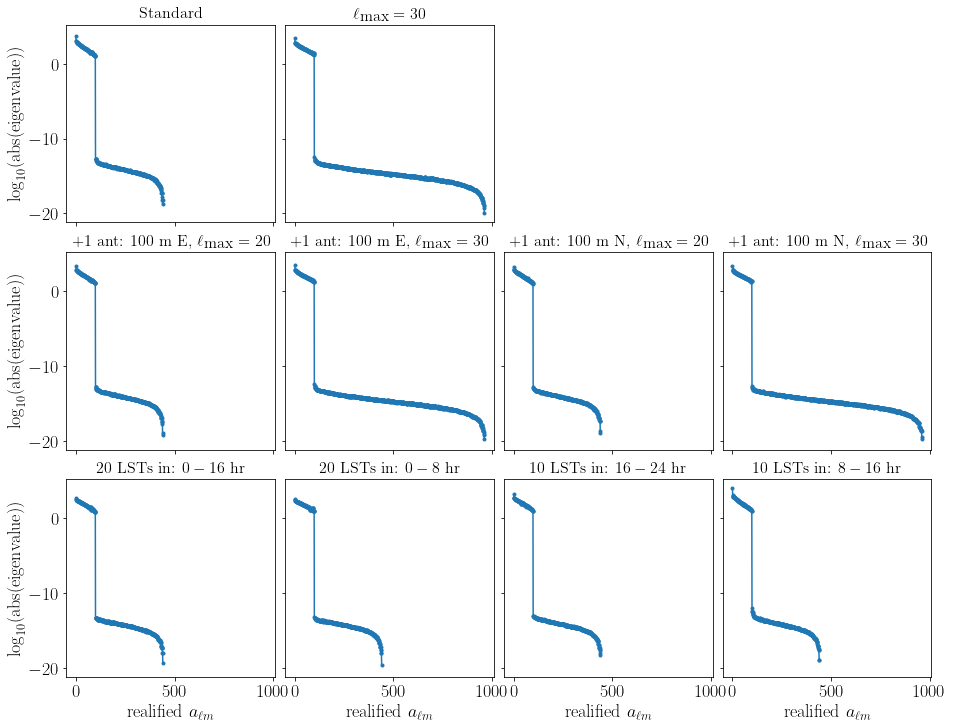

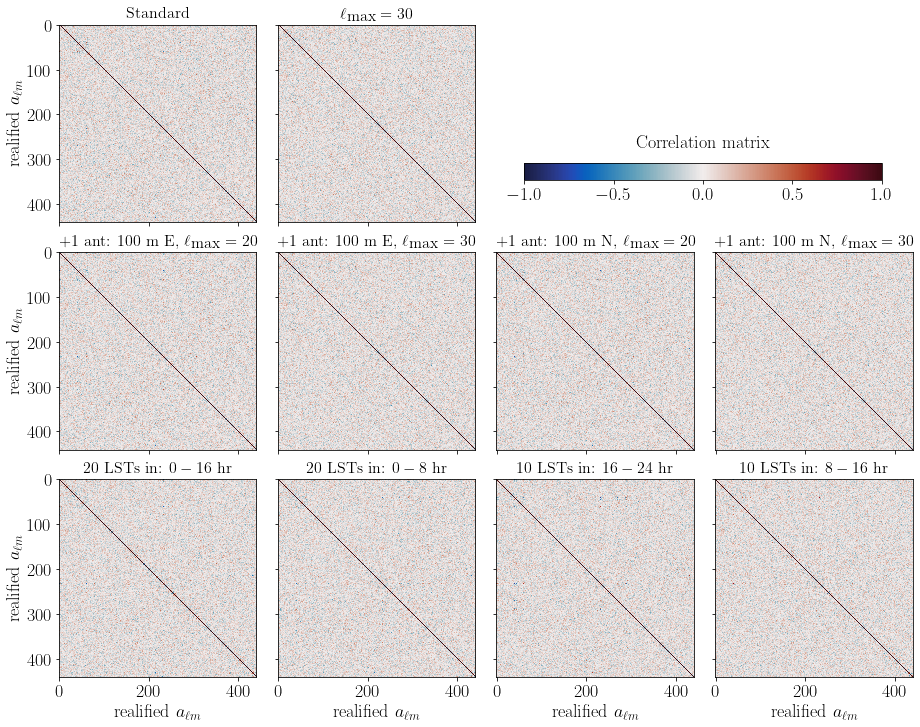

In [65]:
cov_matrix_multiple(folder_list, label_list, vmin=-6, vmax=8)

## $\Delta_{\ell}$ and variance-plots

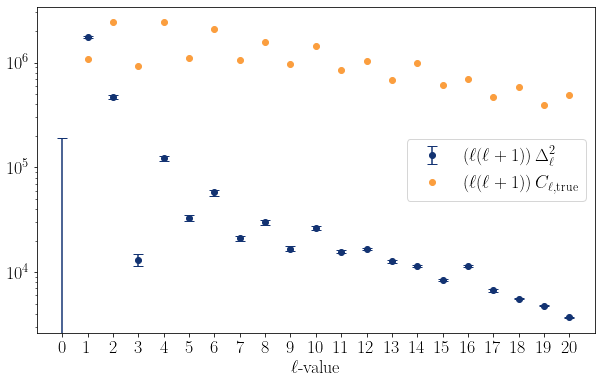

In [66]:
delta_l_plot(x_solns, x_true, lmax, filename='delta_ell',log=True, display=True)

The $C_{\ell}$ plot looks (very) different if I use `hp.alm2cl()` instead

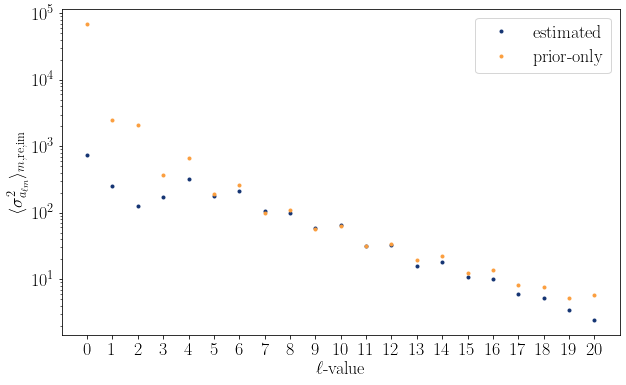

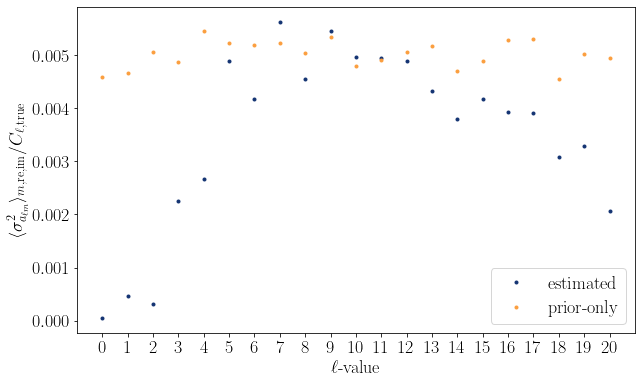

In [67]:
if prior_file:
    var_plot(x_solns, x_true, lmax, x_priors=prior_x_solns, filename='mean_variance_ell', display=True)
else:
    var_plot(x_solns, x_true, lmax, filename='mean_variance_ell', display=True)

## Matrix plot of $X$-operator (`vis_response`)

### Layering of matrix when using `.reshape()`

```
    vis_response = np.zeros((len(antpairs),len(freqs),len(lsts),2*len(ell)-(lmax+1)), dtype=np.complex128)


    ## Reshape to 2D                                      ## TODO: Make this into a "pack" and "unpack" function
    # Nbl, Nfreqs, Ntimes, Nalms --> Nvis, Nalms
    Nvis = len(antpairs) * len(freqs) * len(lsts)
    # Nvis = np.prod([len(antpairs),*vis_alm.shape[:-3]])
    vis_response_2D = vis_response.reshape(Nvis, 2*len(ell)-(lmax+1))
```

#### Dummy example

from shape (4, 3, 5, 10) to shape (60, 10)



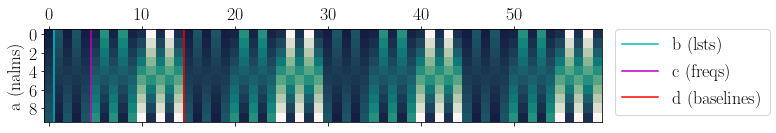

In [68]:
a = np.array([1,2,3,4,5,6,7,8,9,10])   # fourth dim = 10 # NALMS
b = np.array([a,np.flip(a),a,np.flip(a),a])              # third dim  = 5  # Nlsts
c = np.array([b, 2*b, 4*b])            # second dim = 3  # Nfreq
d = np.array([c, c, c, c])             # first dim = 4   # Nbls

dummy = d.reshape((len(d)*len(c)*len(b), len(a)))

fig, ax = plt.subplots(ncols=1,figsize=(10,6))
ax.matshow(dummy.T,cmap=cmo.tempo_r)

d_border = dummy.shape[0]/len(d)
c_border = d_border/len(c)
b_border = c_border/len(b)

plt.plot((np.ones(100)*b_border-0.5),(np.linspace(0,10,100)-0.5),'c',label='b (lsts)')   # b (nlsts) 
plt.plot((np.ones(100)*c_border-0.5),(np.linspace(0,10,100)-0.5),'m',label='c (freqs)')  # c (nfreq)
plt.plot((np.ones(100)*d_border-0.5),(np.linspace(0,10,100)-0.5),'r',label='d (baselines)')  # d (nbls)

plt.ylabel('a (nalms)')
plt.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0)
print(f'from shape {d.shape} to shape {dummy.shape}\n')

### Plotting `vis_response` operator

In [69]:
# Baselines (didn't output this! So recalculating)
autos_only = False
include_autos = False

if not os.path.isfile(path+'ant_pos.npz'):
    ants = list(ant_pos.keys())
    antpairs = []
    
else:
    ants = [int(ant) for ant in dict_ants]
    antpairs = []
    
if autos_only == False and include_autos == False:
    auto_ants = []
for i in ants:
    for j in ants:
        # Toggle via keyword argument if you want to keep the auto baselines/only have autos
        if include_autos == True:
            if j >= i:
                antpairs.append((ants[i],ants[j]))
        elif autos_only == True:
            if j == i:
                antpairs.append((ants[i],ants[j]))
        else:
            if j == i:
                auto_ants.append((ants[i],ants[j]))
            if j > i:
                antpairs.append((ants[i],ants[j]))
                    
ant_labels = antpairs
ant_labels[0] = f'bl = {antpairs[0]}'

In [70]:
Nlsts = len(lsts_hours)
Nfreq = len(freqs)
Nbl = vis_response.shape[0]//Nfreq//Nlsts
assert(Nbl == len(antpairs))
Nalm = vis_response.shape[1]
Nvis = Nlsts*Nfreq*Nbl

bl_border = vis_response.shape[0]/Nbl # bls  d
freq_border = bl_border/Nfreq # nfreqs  c 
lsts_border = freq_border/Nlsts # nlsts b

idx_x = [i for i in range(0, Nvis, Nvis//Nbl)]
ems, idx_y = get_em_labels(lmax)

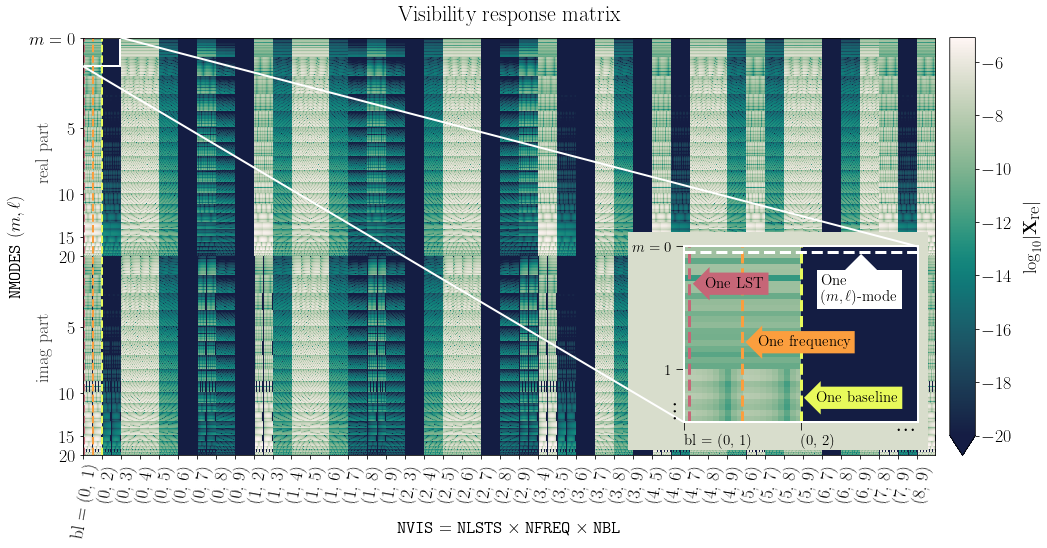

In [71]:
fig, ax1 = plt.subplots(nrows=1, figsize=(16,9)) 
log_operator = np.log(np.abs(np.real(vis_response).T))

# vmin = log_operator.min()
vmin = -20
vmax = log_operator.max()
# vmax = -5

if vmin < log_operator.max(): extend = 'min'
im1 = ax1.matshow(log_operator, cmap=cmo.tempo_r, vmin=vmin, vmax=vmax)

# Labels and ticks on parent plot
# fig.colorbar(im1, ax=ax1)
plt.xlabel(r'$\texttt{NVIS} = \texttt{NLSTS}\times\texttt{NFREQ}\times\texttt{NBL}$',labelpad=-20)
plt.ylabel(r'$\texttt{NMODES}$ $(m,\ell)$')#, labelpad=-15)
plt.title(r'Visibility response matrix')

# annotate y-axis with "real-" and "imag part"
ax1.text(-50,150,'real part',rotation='90',color='0.2')
ax1.text(-50,360,'imag part',rotation='90',color='0.2')

xlabels = pyplot.xticks(idx_x,ant_labels,rotation=80, ha="right", rotation_mode="anchor") 
ylabels = pyplot.yticks(idx_y[::5],ems[::5],rotation=0) 

ax1.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

# plt.gcf().set_size_inches((18., 6.))

# Set colorbar to graph size 
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(im1, cax=cax, extend=extend)
cbar.set_label(r'$\textup{log}_{10}|\mathbf{X}_\textup{re}|$', labelpad=10)


# Save final figure
fig.savefig(figpath+'X_operator'+'.pdf', 
    bbox_inches='tight', 
    transparent=True, 
    dpi=fig.dpi,
    facecolor='white')

inset = True
if inset:
    # discrete colormaps for nice colors for lines
    cmap10 = discrete_cmap(10,cmo.tempo_r)
    arrow_color = cmap10(1)
    background_color = cmap10(8)
    inset_linecolor = 'white'#cmap10(3)
    font_color = 'black'#cmap10(0)
    arrow_borders = discrete_cmap(10,cmo.thermal)
    
    # Create a set of inset Axes: these should fill the bounding box allocated to
    # them.
    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.692,0.08,0.3,0.42])
    ax2.set_axes_locator(ip)

    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # imshow has inverted axes, set lines manually:
    patch, pp1, pp2 = mark_inset(ax1, ax2, loc1=1,loc2=1,ec=inset_linecolor,lw=2)
    pp1.loc1 = 3 # inset, ll
    pp1.loc2 = 2 # parent, ll
    pp2.loc1 = 1 # inset, ur
    pp2.loc2 = 4 # parent, ur

    # The content of the inset
    im2 = ax2.matshow(np.log(np.abs(np.real(vis_response).T)[:30,:40]), cmap=cmo.tempo_r,
                     vmin=vmin, vmax=vmax)
    
    # lst indicator (parent+inset)   
    ax1.axvline(lsts_border,ls="--",color=arrow_borders(5), lw=2)  # b (nlsts) 
    ax2.axvline(lsts_border-0.5,ls="--",color=arrow_borders(5),lw=3)  # b (nlsts) 
    ax2.text(lsts_border+2.2,6.5,
            'One LST',
            fontsize='15',
            bbox=dict(boxstyle="larrow",
                      fc=arrow_borders(5), 
                      ec=arrow_borders(5),
                      lw=0, 
                      alpha=1))

    # frequency indicator (parent+inset)
    ax1.axvline(freq_border,ls="--",color=arrow_borders(7), lw=2)    # c (nfreq)
    ax2.axvline(freq_border-0.5,ls="--",color=arrow_borders(7), lw=3)    # c (nfreq)
    ax2.text(freq_border+2.2,16.5,
            'One frequency',
            fontsize='15',
            bbox=dict(boxstyle="larrow",
                      fc=arrow_borders(7), 
                      ec=arrow_borders(7), 
                      lw=0, 
                      alpha=1))
    
    # baseline indicator (parent+inset)
    ax1.axvline(bl_border,ls="--",color=arrow_borders(9),lw=2)         # d (nbls)
    ax2.axvline(bl_border-0.5,ls="--",color=arrow_borders(9), lw=3)         # d (nbls)
    ax2.text(bl_border+2.2,26,
            'One baseline',
            fontsize='15',
            bbox=dict(boxstyle="larrow",
                      fc=arrow_borders(9), 
                      ec=arrow_borders(9), 
                      lw=0, 
                      alpha=1))

    # (m,l)-mode indicator (only inset as it looks strange on parent plot)
    # ax1.axhline(0.5,ls="--",color="white",lw=2) 
    ax2.axhline(0.5,ls="--",color="white",lw=3) 
    ax2.text(bl_border+8.7,2.4,
            '   ',
            fontsize='15',
            bbox=dict(boxstyle="rarrow",
                      fc="white", 
                      ec="white", 
                      lw=0, 
                      alpha=1),
            rotation='90')
    ax2.text(bl_border+3,8.7,
            'One\n'+' $(m,\ell)$-mode',
            fontsize='15',
            bbox=dict(boxstyle="square",
                      fc="white",#arrow_color, 
                      ec="white", 
                      lw=0, 
                      alpha=1))

    _ = pyplot.yticks([i-0.5 for i in idx_y[:2]],ems[:2],rotation=0, fontsize='15',color=font_color) 
    _ = pyplot.xticks([i-0.5 for i in idx_x[:2]],ant_labels[:2],
                      rotation=0, ha="left", rotation_mode="anchor", 
                      fontsize='15',color=font_color) 
    
    ax2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True, color=font_color)

    ax2.text(36,31,'...',fontsize='30',color=font_color)
    ax2.text(-5.3,28,'...',fontsize='30',rotation='90',color=font_color)

    ax2.spines[:].set_color(inset_linecolor)
    ax2.spines[:].set_linewidth(2)
    ax2.tick_params(length=8)
    
    background = mpl.patches.Rectangle(xy=(575,205), 
                                       width=317, 
                                       height=230,
                                       alpha = 1,
                                       edgecolor = None,#inset_linecolor,
                                       facecolor = background_color,
                                       lw=0,
                                       fill=True,
                                       zorder=10)

    ax1.add_patch(background)
    
    # Save final figure
    fig.savefig(figpath+'X_operator'+'_with_inset'+'.pdf', 
            bbox_inches='tight', 
            transparent=True, 
            dpi=300,#fig.dpi,
            facecolor='white')


# NOTES

## Prior variance defined in code
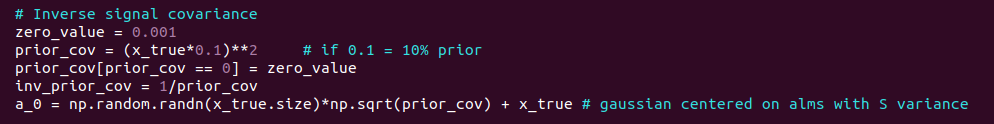



## Checking units of pygsm
Check that the K_CMB unit is equivalent to K_RJ at 100 MHz 

https://arxiv.org/pdf/1605.04920.pdf eq. 10

In [72]:
boltzmanns_constant = 1.380649*1e-23 #joule per kelvin (K)
plancks_constant = 6.62607015*1e-34 # joule*Hz^-1
freq = 100*1e06 # (M)Hz
T_cmb = 2.7 # Kelvin

planck_relation = (plancks_constant*freq)/(boltzmanns_constant*T_cmb) # unitless 

planck_relation**2 * (np.exp(planck_relation)/(np.exp(planck_relation)-1)**2)

0.9999997367086275